<a href="https://colab.research.google.com/github/Zahra-Ferdous/Thesis_Human_Action_Recognition_from_Depth_Video/blob/main/depth_video_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import math
%matplotlib inline
import os
import time

from numba.core.cgutils import if_likely
#from os.path import exists
import os.path 

import cv2
import sklearn
import scipy.io as sio
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from astropy.timeseries import LombScargle
from scipy.io import loadmat
import imageio
from skimage import feature, transform, data, io
import tensorflow as tf
from PIL import Image



# DEEP LEARNING IMPORTS

from keras.models import Sequential, load_model
from keras.layers import *
# Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Don't run these cells

In [ ]:
dat = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/depth_video_50x64x64.mat')

In [ ]:
X = dat['data'][0]
Y = dat['label'][0]
print(X.shape)
print(Y.shape)

X_train_val , X_test, Y_train_val, Y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42, stratify = Y)

(1165,)
(1165,)


In [ ]:
print(X_train_val.shape)
X_train_val[456].max()
train_len = X_train_val.shape[0]
test_len = X_test.shape[0]

(932,)


In [ ]:
unique, counts = np.unique(Y_train_val, return_counts=True)
print( dict(zip(unique, counts)) )

unique, counts = np.unique(Y_test, return_counts=True)
print( dict(zip(unique, counts)) )


{1: 43, 2: 43, 3: 42, 4: 43, 5: 42, 6: 43, 7: 42, 8: 42, 9: 43, 10: 42, 11: 42, 12: 43, 13: 42, 14: 42, 15: 42, 16: 43, 17: 42, 18: 43, 19: 42, 20: 42, 21: 42, 22: 42}
{1: 10, 2: 10, 3: 11, 4: 10, 5: 11, 6: 10, 7: 11, 8: 11, 9: 10, 10: 11, 11: 11, 12: 10, 13: 11, 14: 11, 15: 11, 16: 10, 17: 11, 18: 10, 19: 10, 20: 11, 21: 11, 22: 11}


In [ ]:

im1 = X_train_val[0]/X_train_val[0].max()
#im1 = cv2.resize(im1, dsize=(64,64))
im1 = im1.reshape(im1.shape[0], 64,64, 1)
X_train_val_norm = np.array([im1])
X_train_val_norm.shape


(1, 50, 64, 64, 1)

In [ ]:
for i in range(1,train_len):
  im1 = X_train_val[i]/X_train_val[i].max()
  im1 = im1.reshape(im1.shape[0], 64,64, 1)
  im1 = np.array([im1])
  X_train_val_norm = np.concatenate((X_train_val_norm,im1), axis = 0)

print(X_train_val_norm.shape)

(932, 50, 64, 64, 1)


In [ ]:
im1 = X_test[0]/X_test[0].max()
im1 = im1.reshape(im1.shape[0], 64,64, 1)
X_test_norm = np.array([im1])
X_test_norm.shape

(1, 50, 64, 64, 1)

In [ ]:
for i in range(1,test_len):
  im1 = X_test[i]/X_test[i].max()
  im1 = im1.reshape(im1.shape[0], 64,64, 1)
  im1 = np.array([im1])
  X_test_norm = np.concatenate((X_test_norm,im1), axis = 0)

X_test_norm.shape

(233, 50, 64, 64, 1)

In [ ]:


sio.savemat('/content/drive/MyDrive/Colab Notebooks/depth_video_50x64x64x1_scaled.mat',{'train_x': X_train_val_norm, 'test_x': X_test_norm, 'train_y':Y_train_val, 'test_y': Y_test})

## Execute from here

In [ ]:
dat = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/depth_video_50x64x64x1_scaled.mat')

In [ ]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y'])

In [ ]:
train_x = dat['train_x']
train_y = dat['train_y'][0] - 1
test_x = dat['test_x']
test_y = dat['test_y'][0] - 1

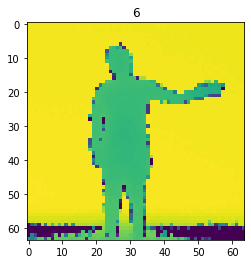

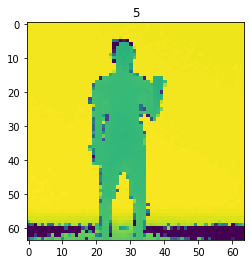

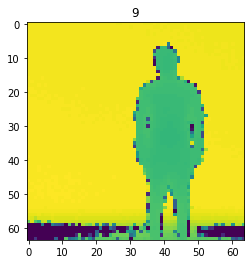

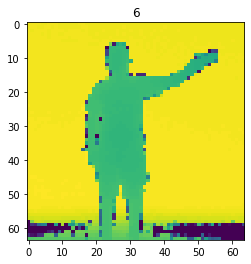

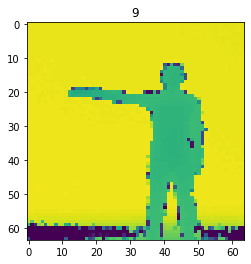

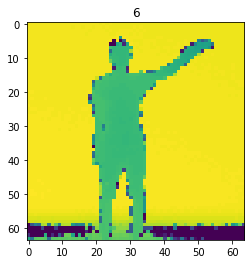

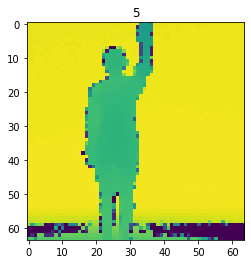

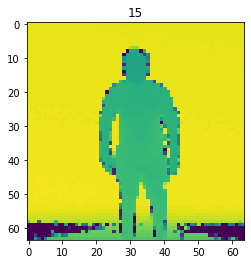

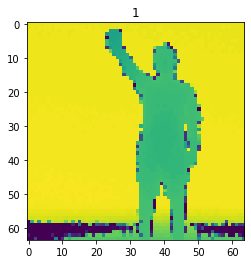

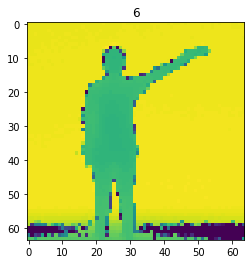

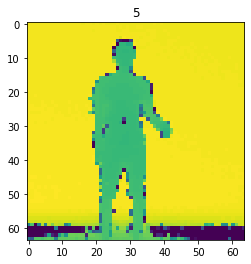

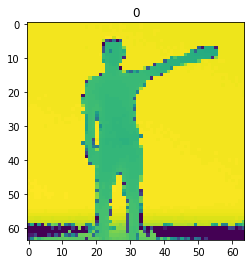

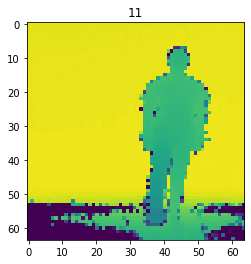

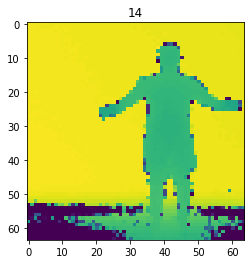

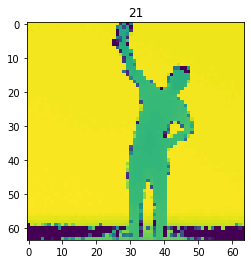

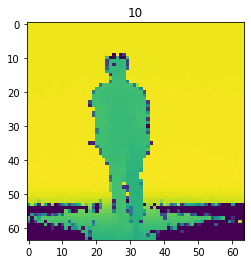

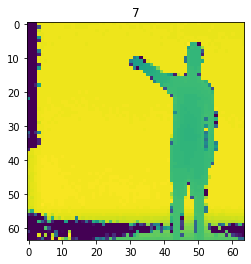

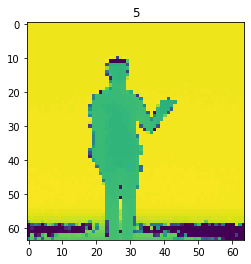

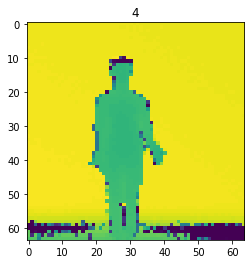

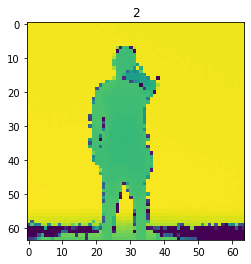

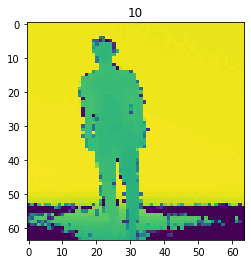

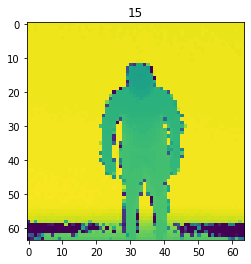

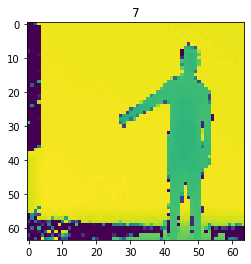

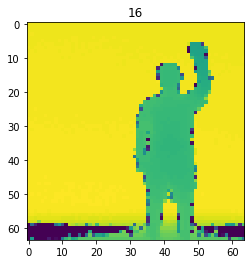

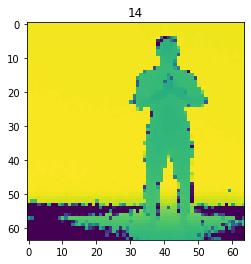

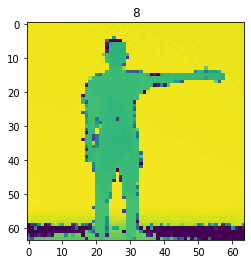

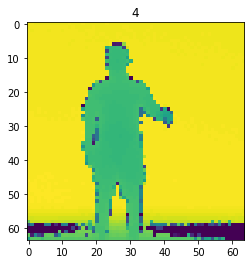

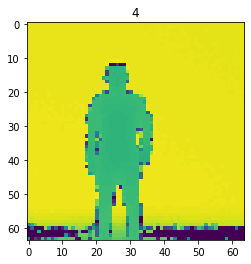

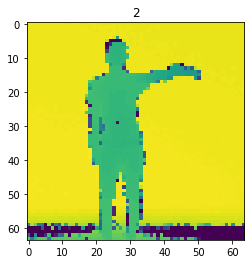

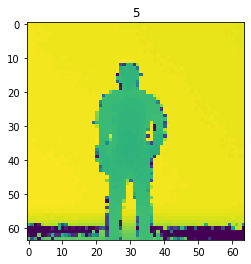

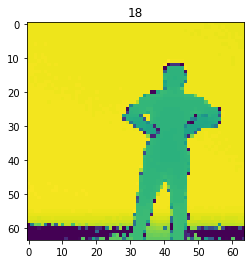

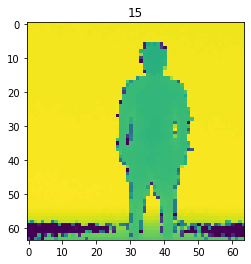

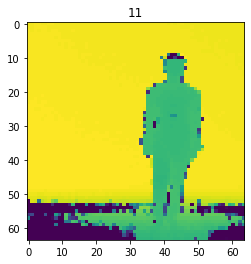

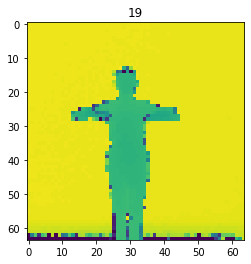

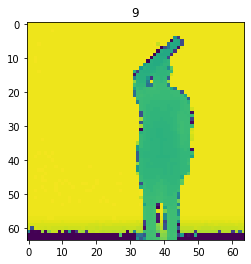

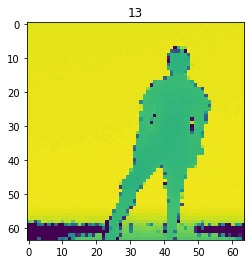

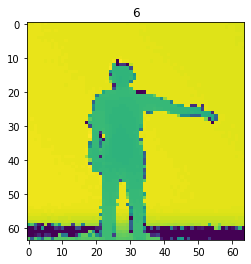

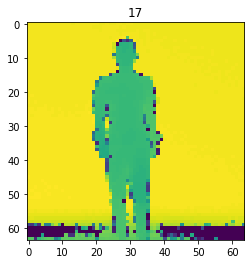

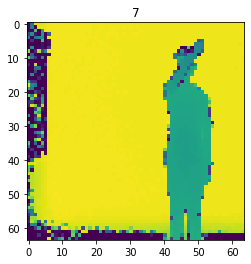

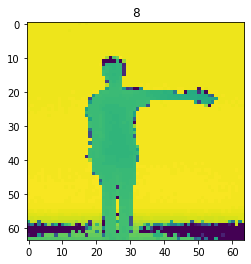

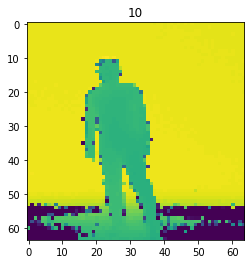

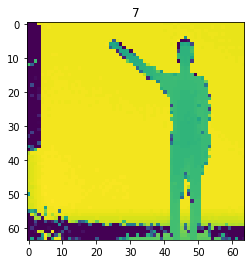

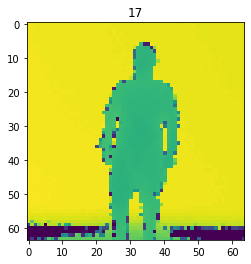

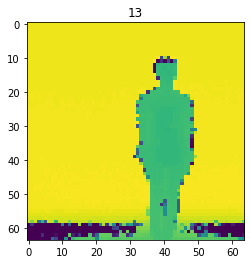

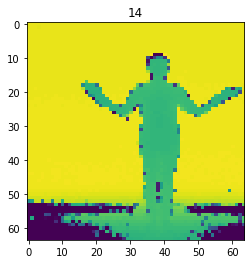

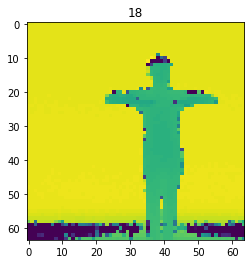

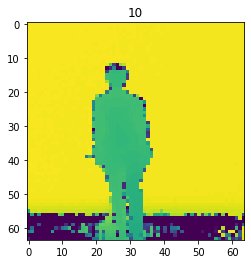

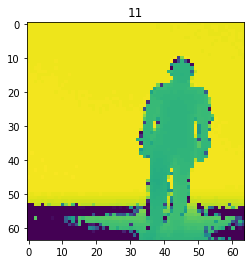

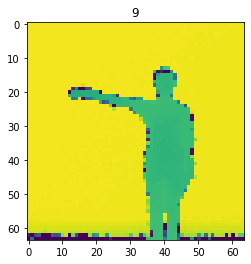

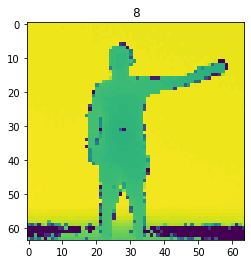

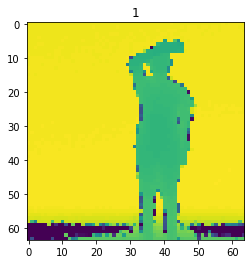

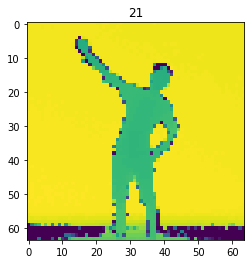

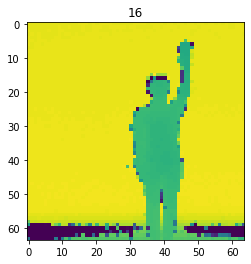

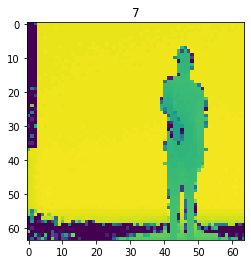

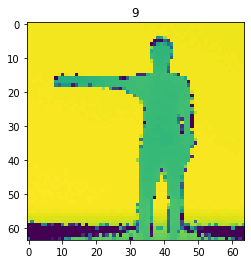

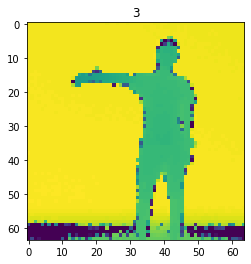

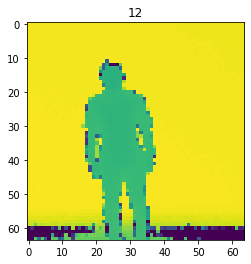

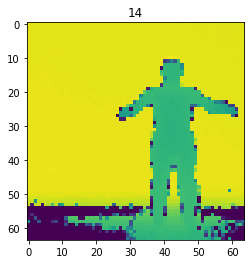

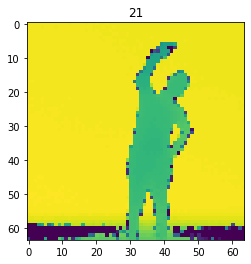

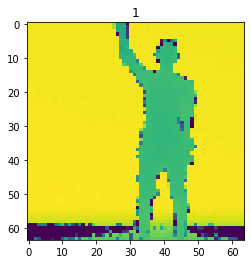

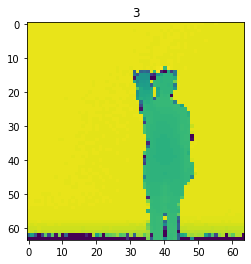

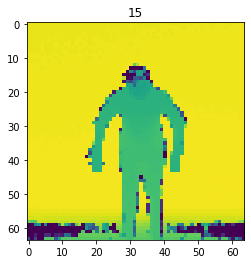

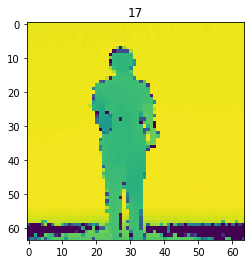

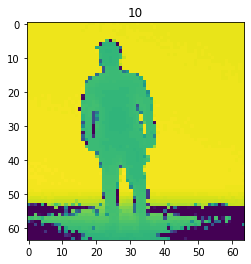

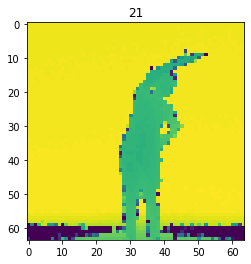

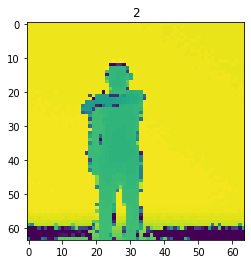

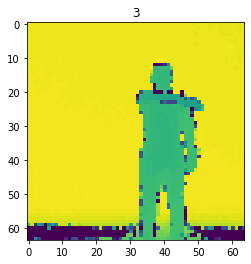

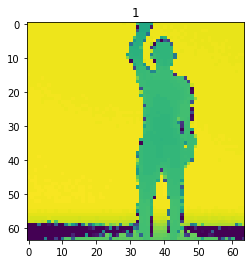

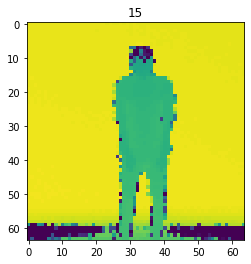

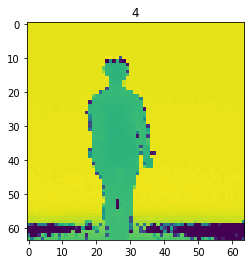

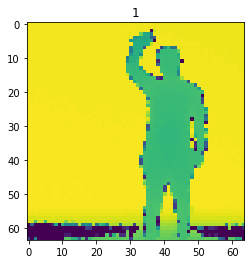

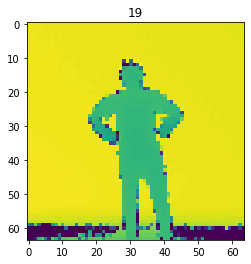

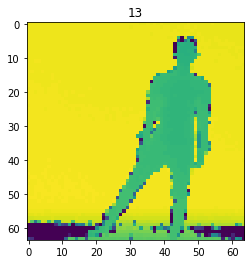

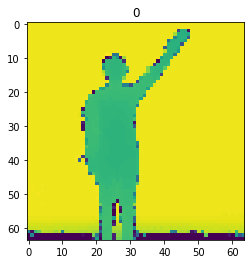

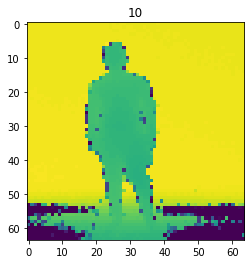

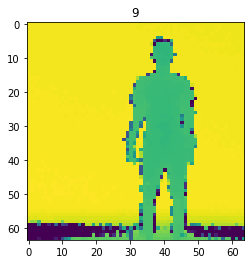

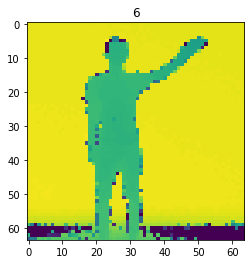

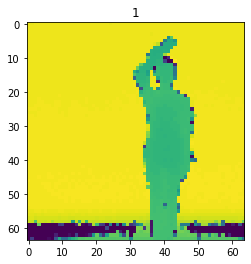

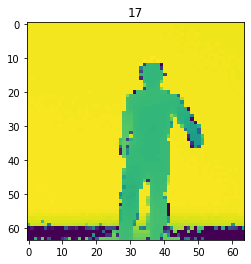

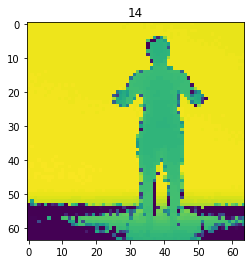

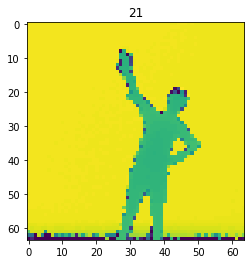

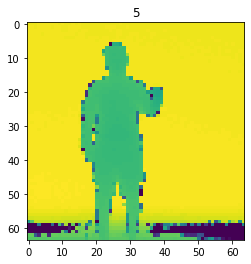

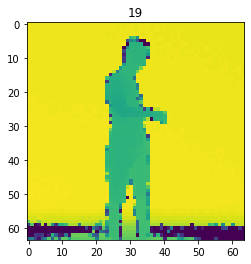

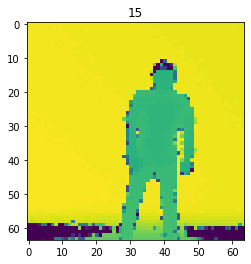

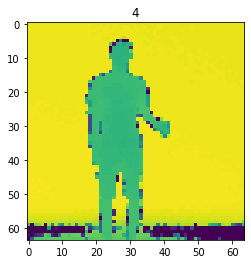

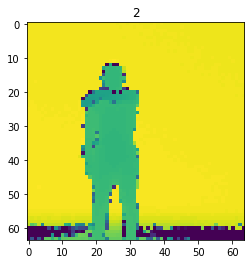

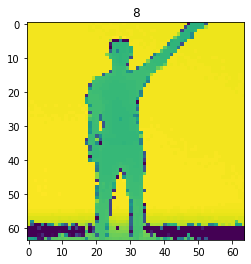

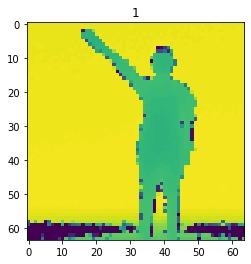

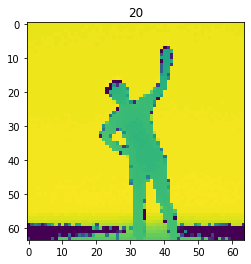

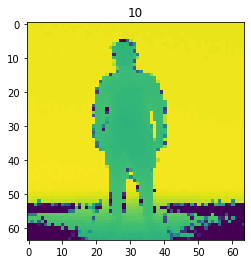

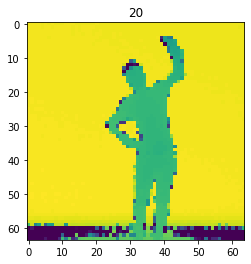

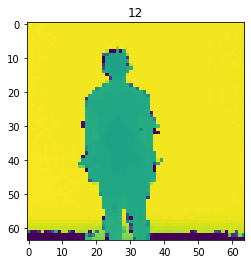

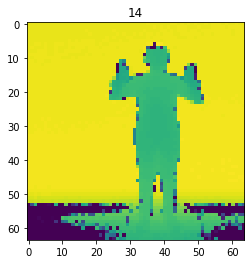

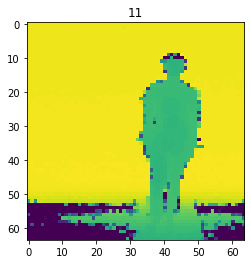

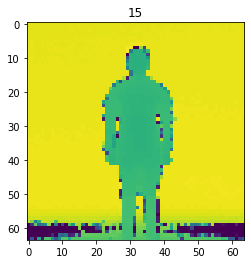

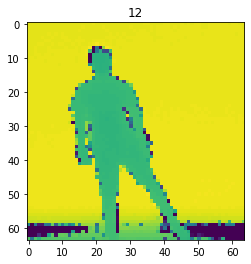

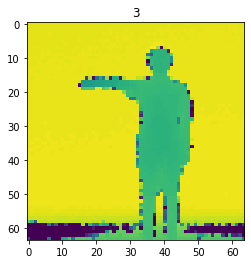

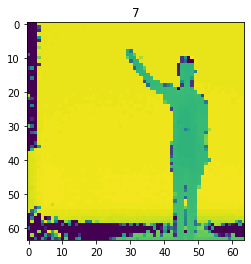

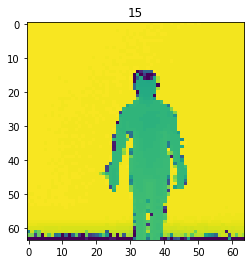

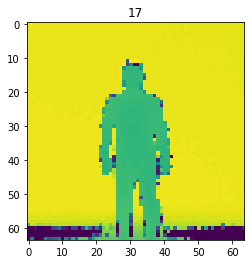

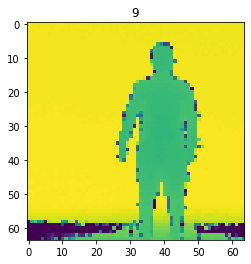

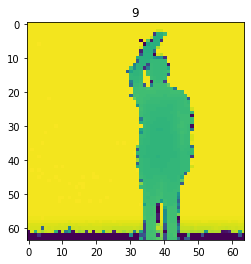

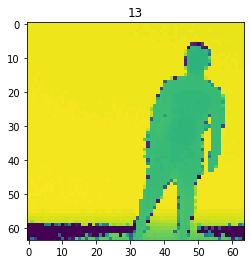

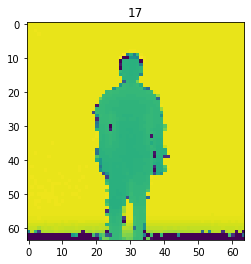

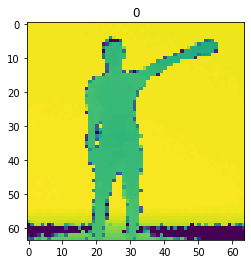

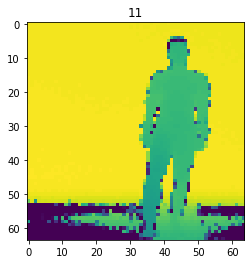

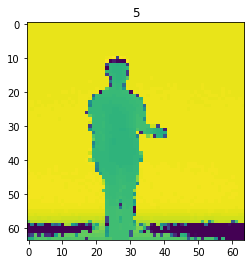

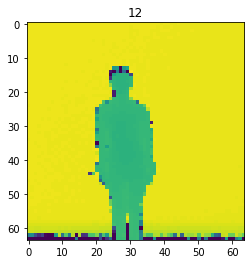

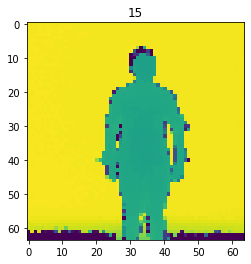

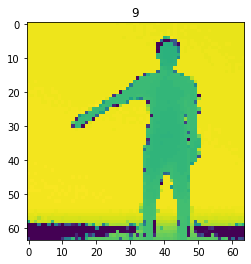

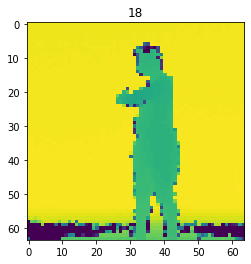

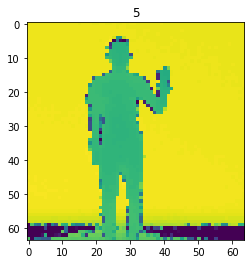

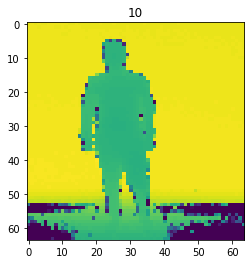

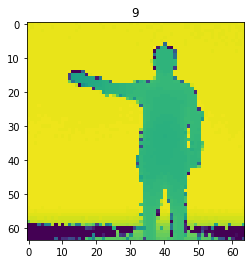

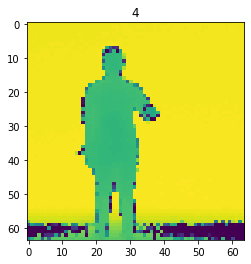

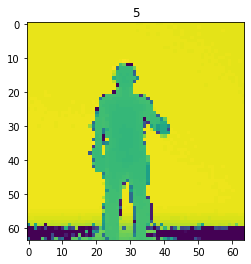

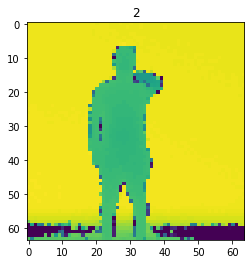

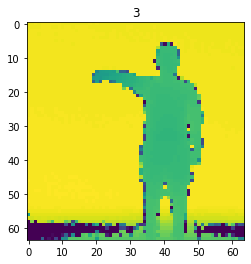

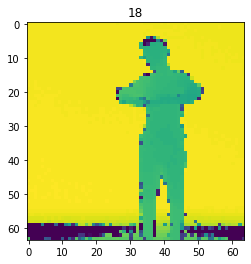

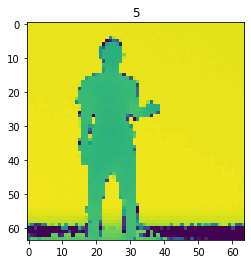

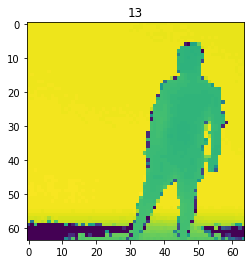

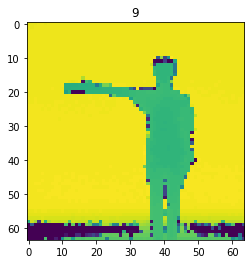

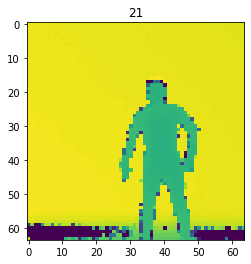

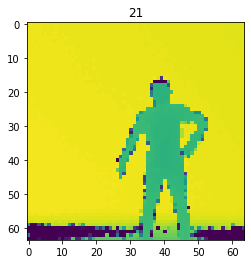

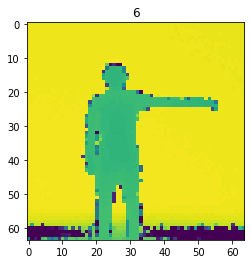

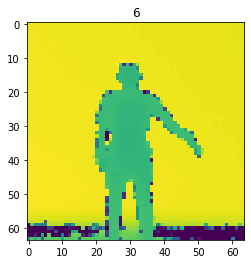

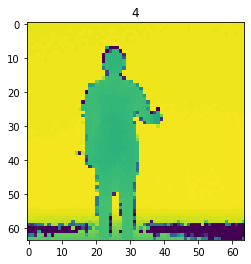

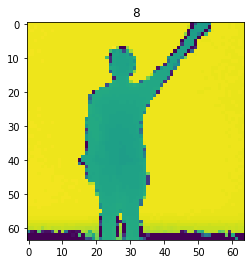

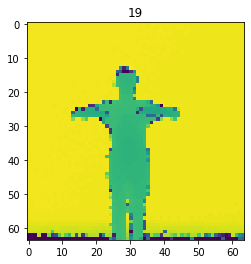

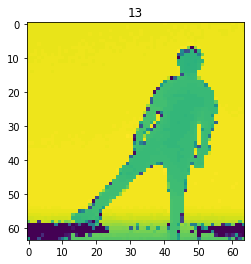

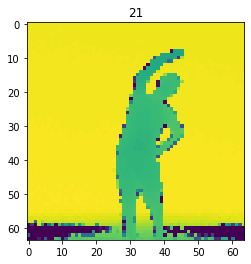

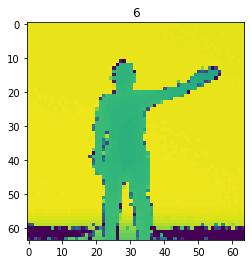

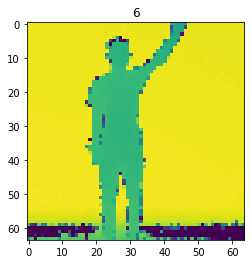

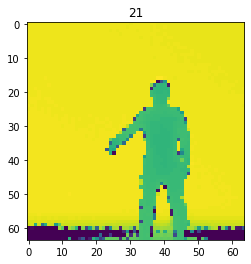

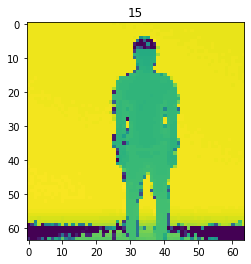

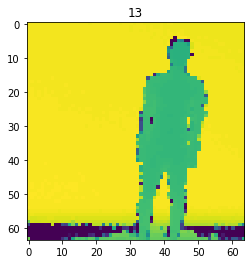

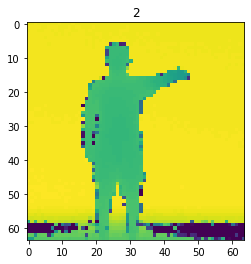

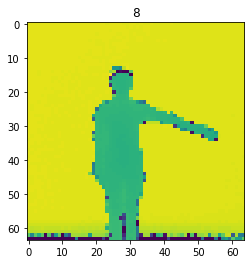

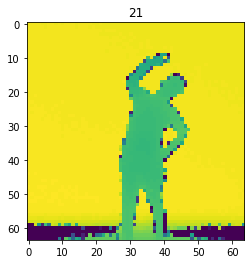

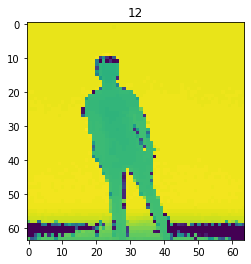

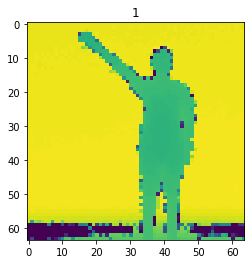

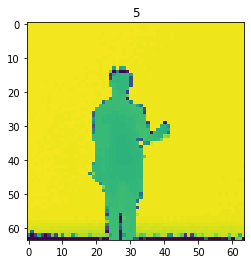

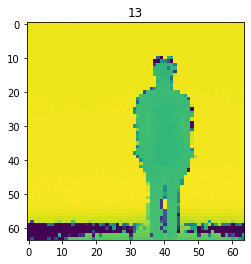

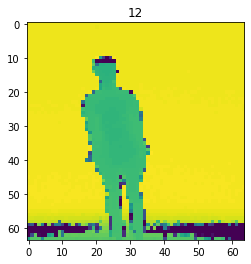

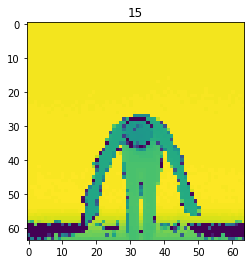

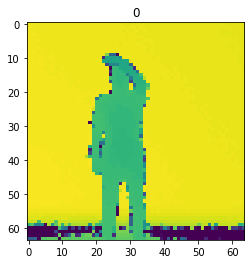

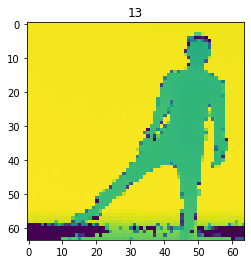

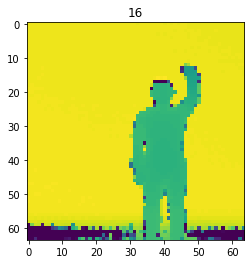

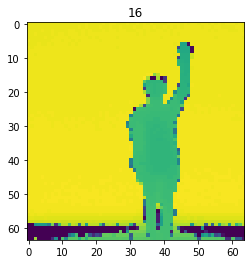

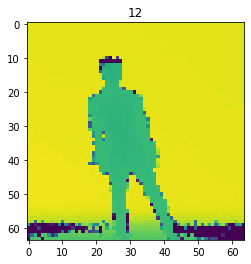

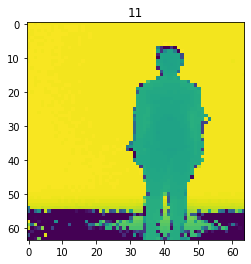

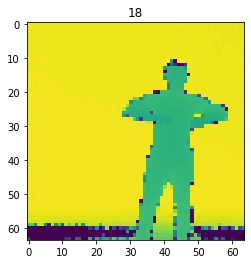

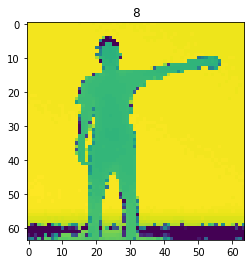

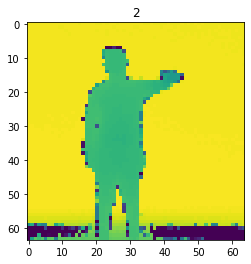

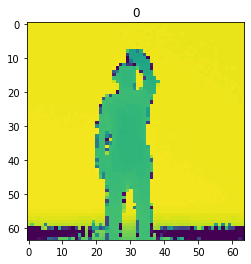

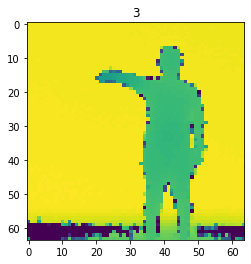

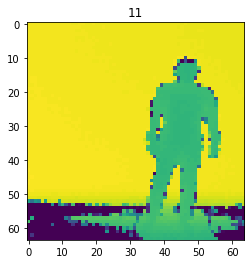

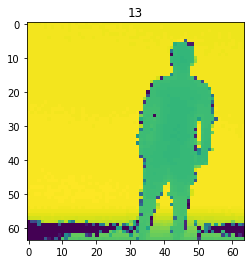

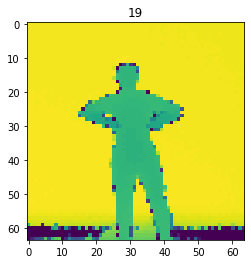

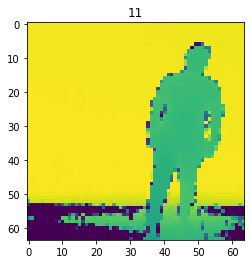

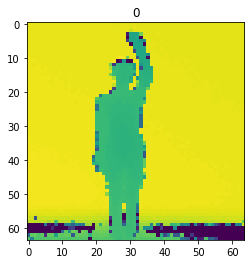

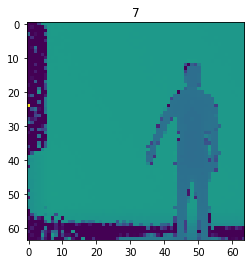

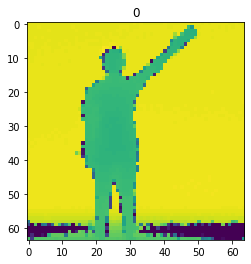

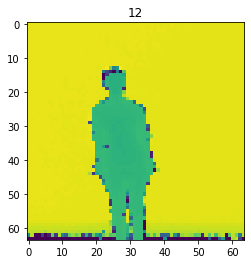

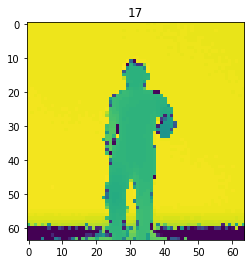

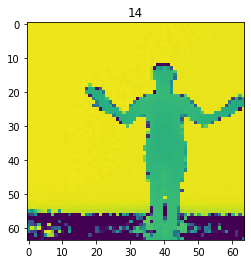

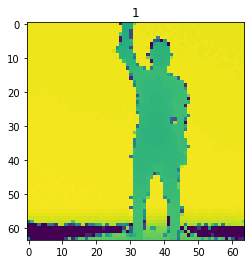

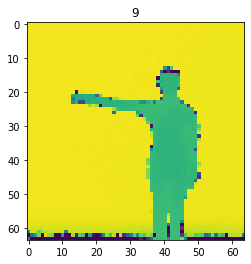

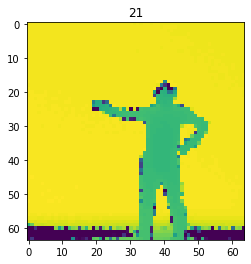

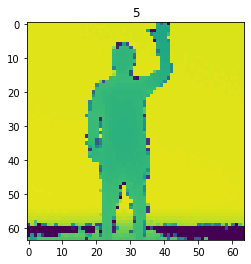

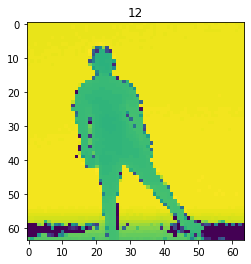

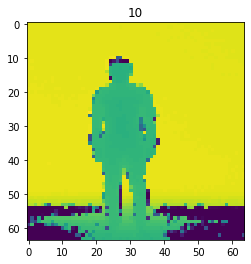

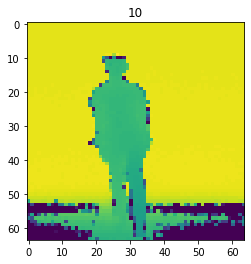

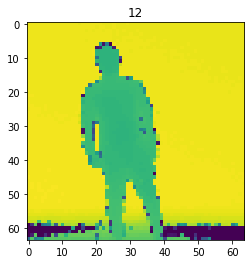

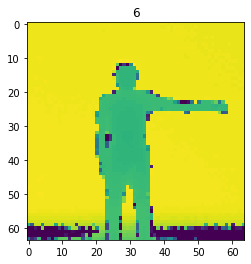

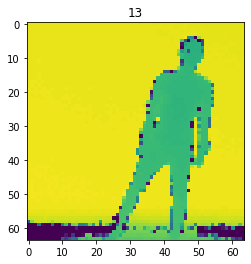

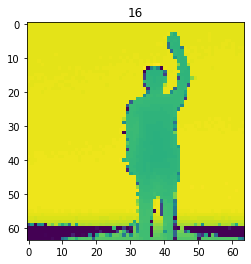

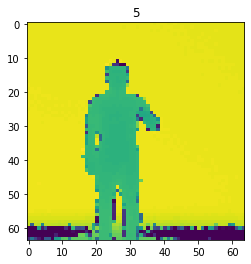

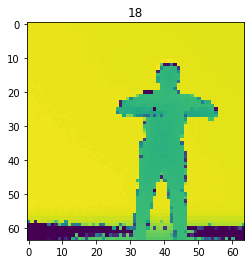

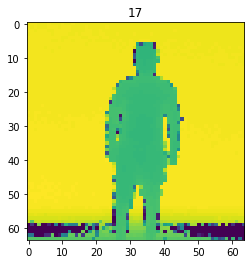

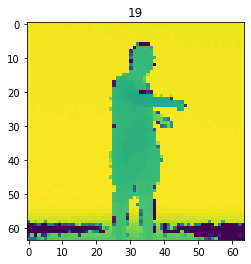

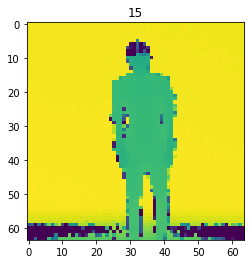

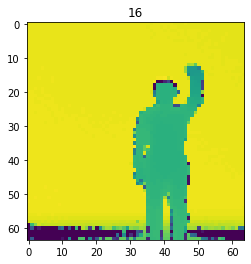

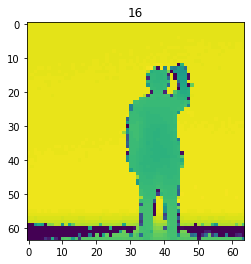

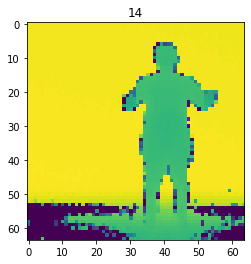

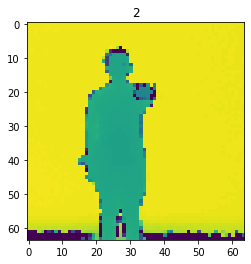

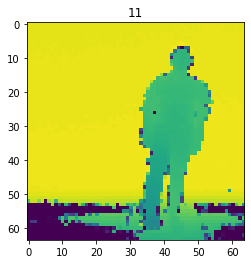

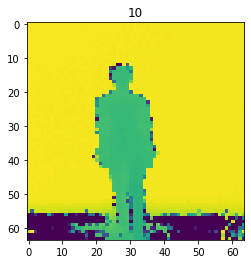

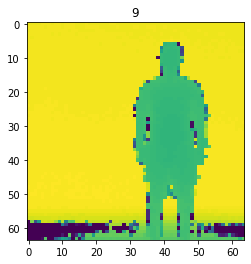

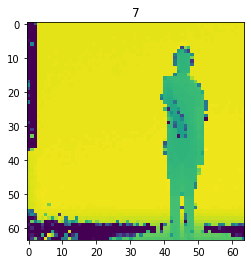

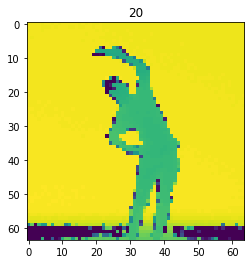

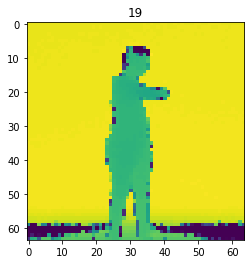

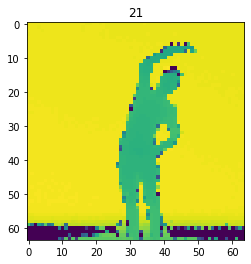

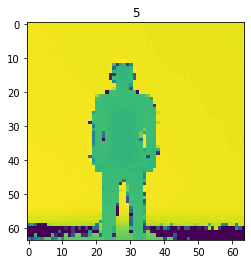

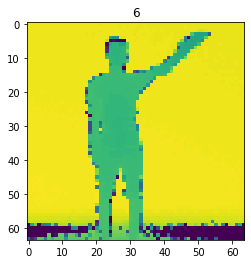

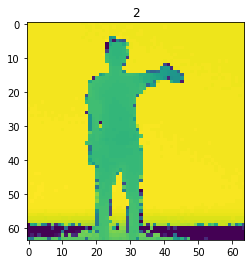

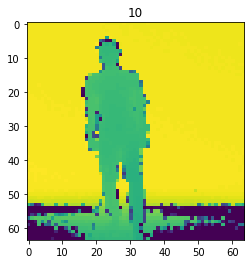

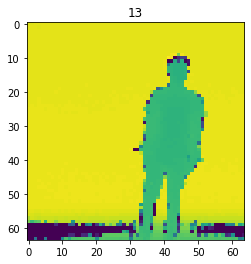

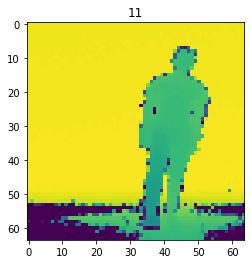

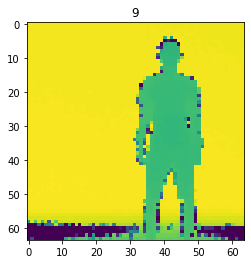

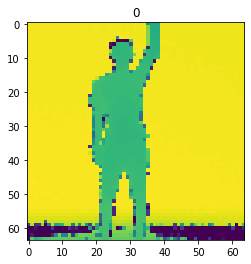

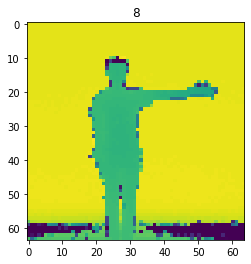

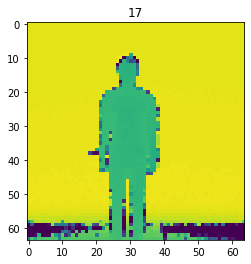

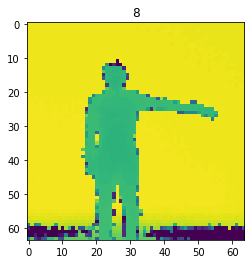

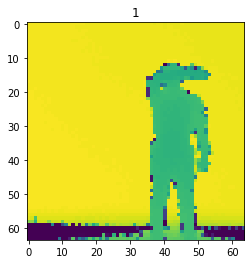

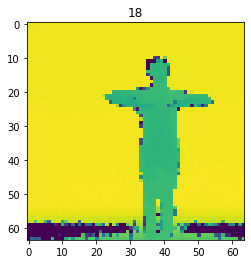

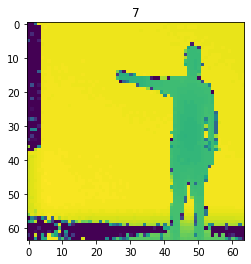

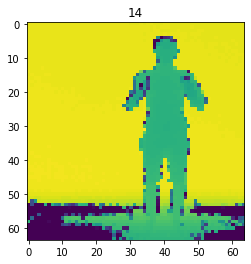

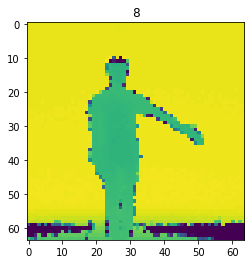

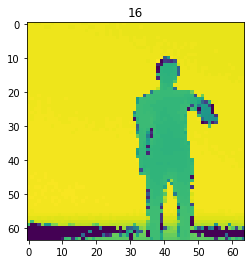

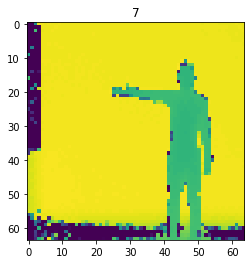

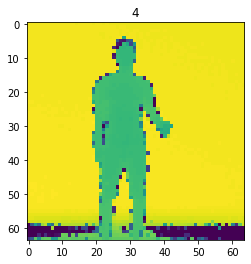

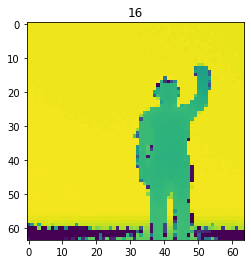

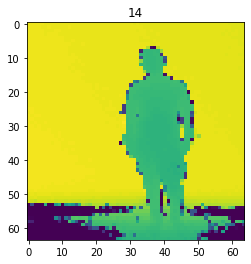

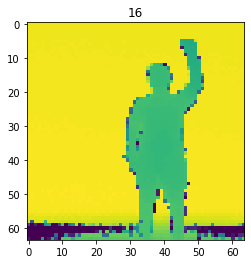

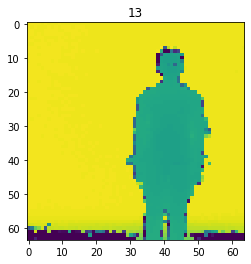

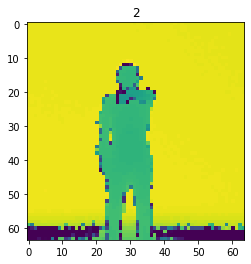

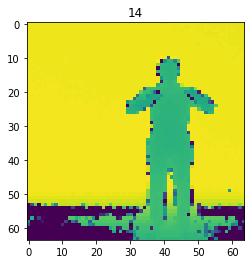

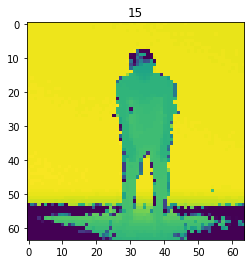

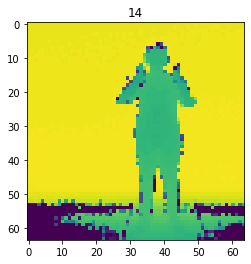

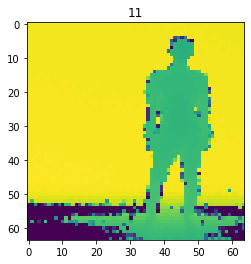

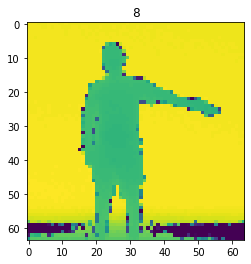

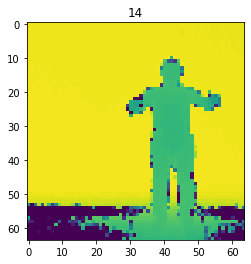

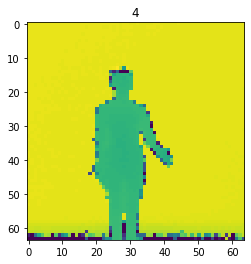

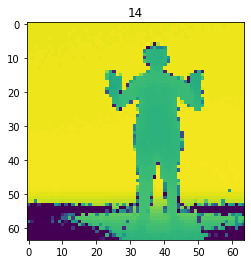

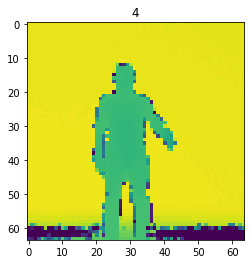

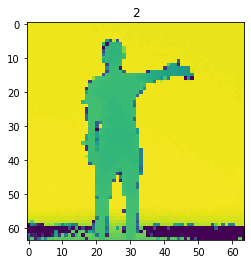

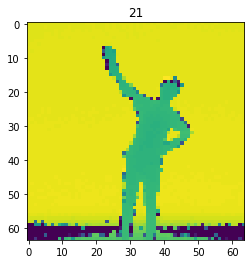

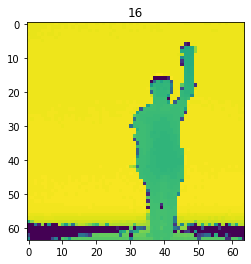

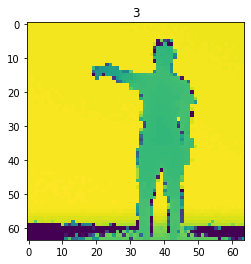

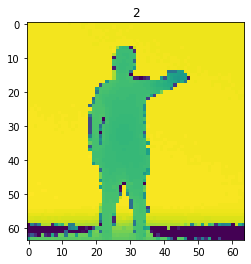

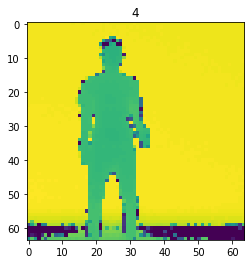

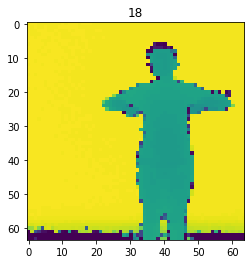

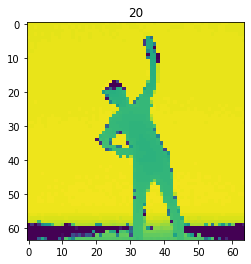

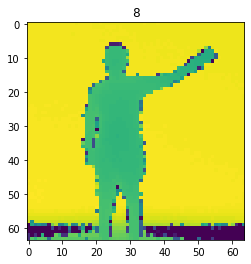

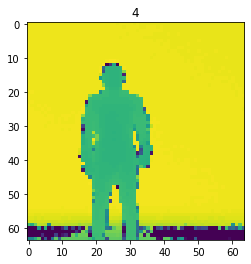

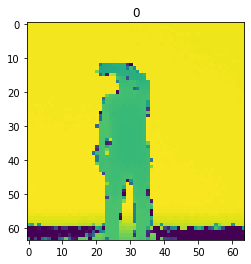

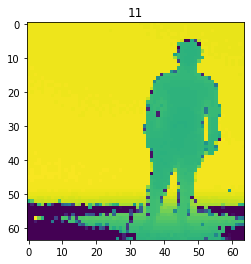

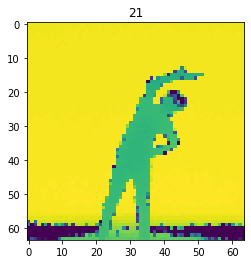

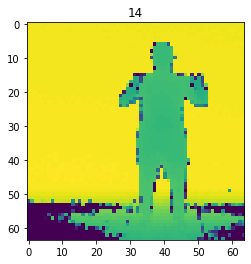

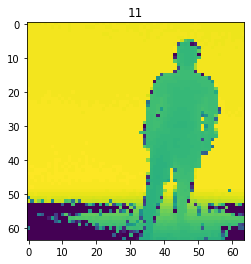

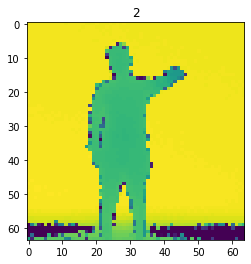

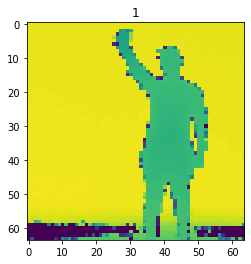

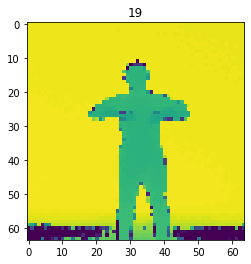

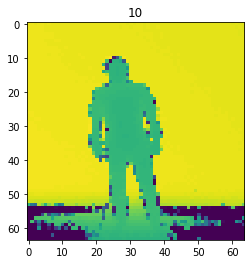

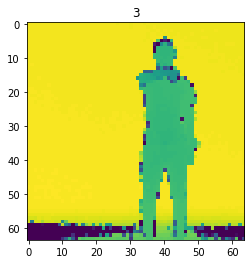

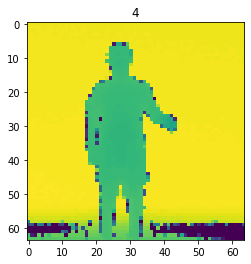

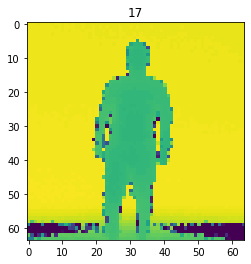

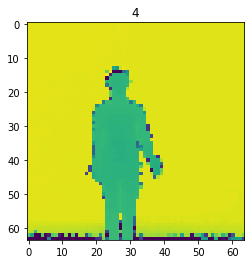

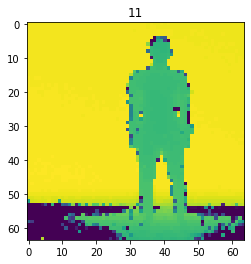

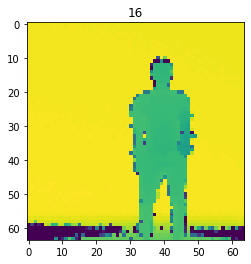

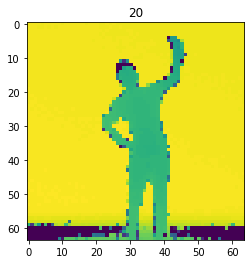

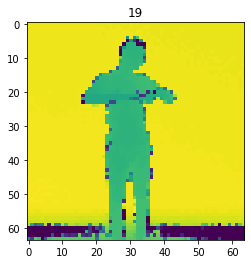

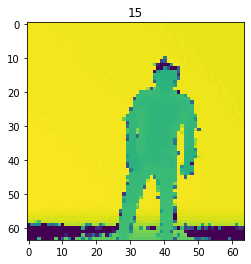

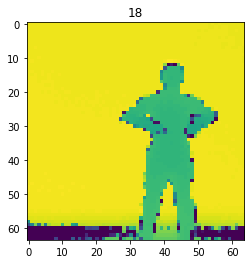

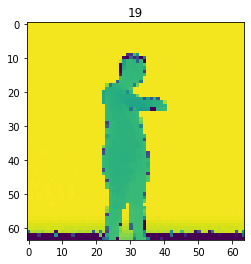

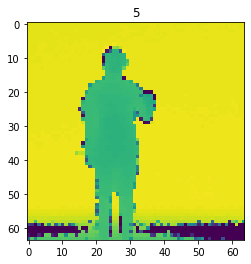

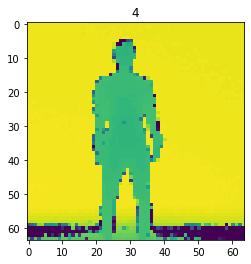

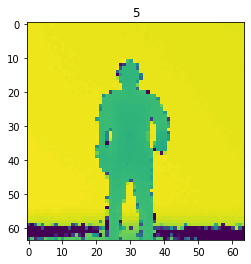

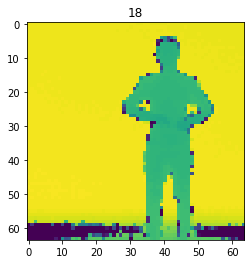

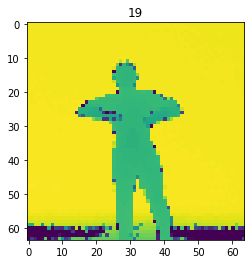

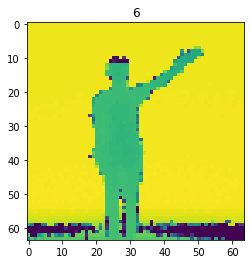

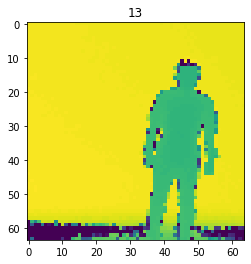

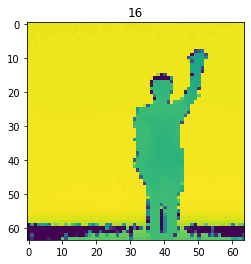

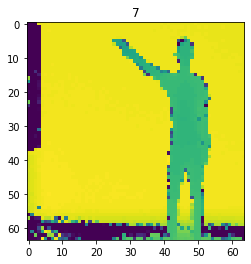

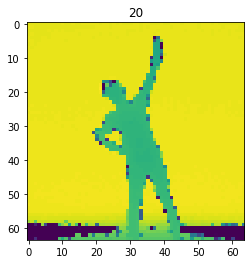

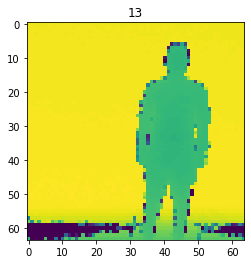

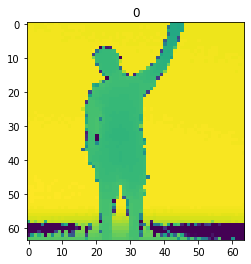

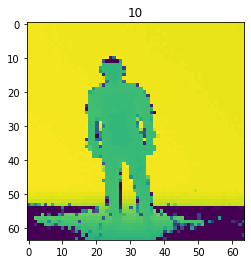

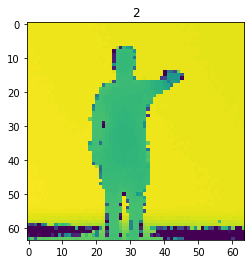

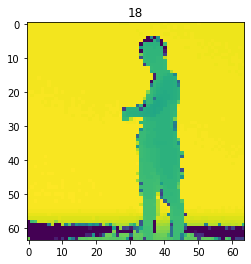

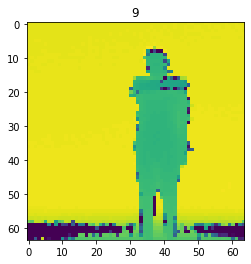

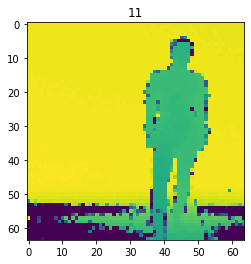

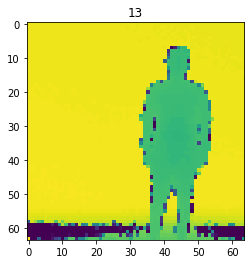

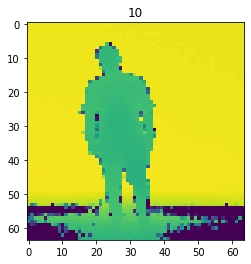

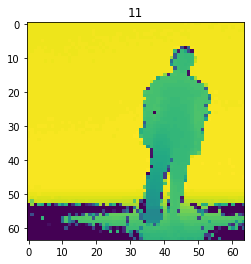

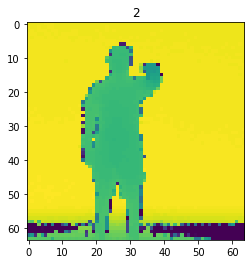

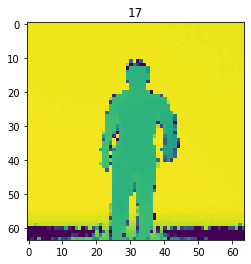

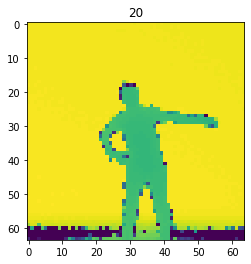

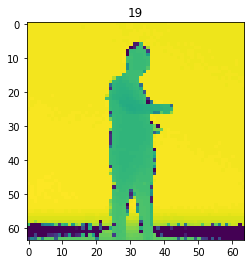

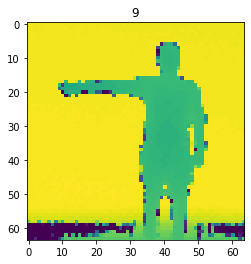

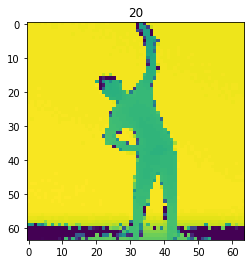

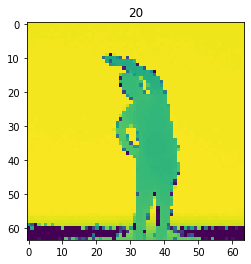

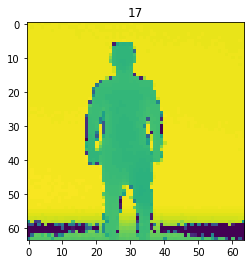

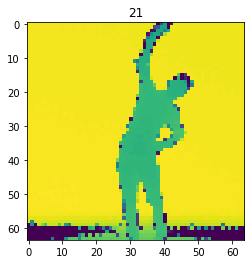

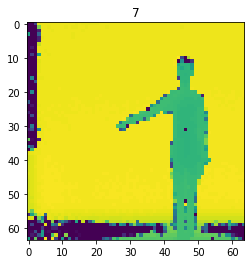

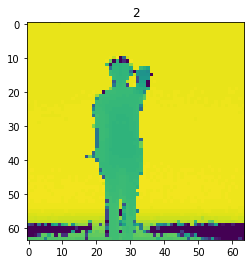

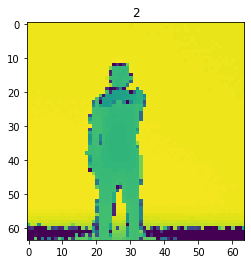

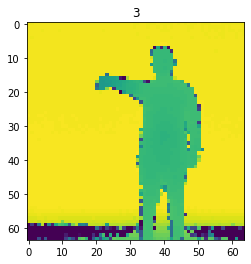

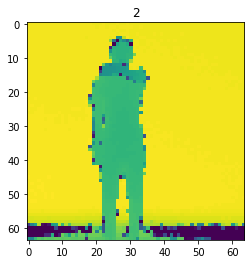

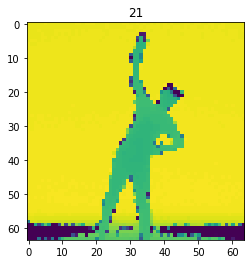

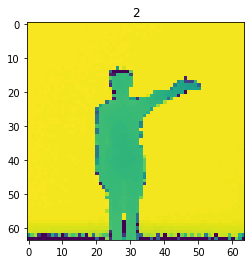

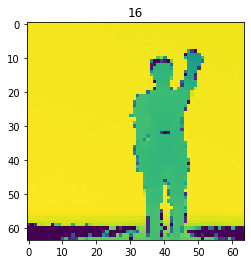

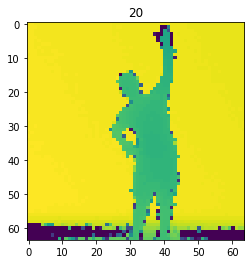

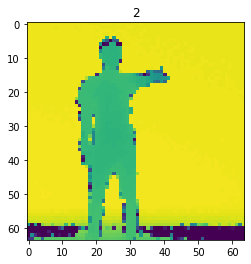

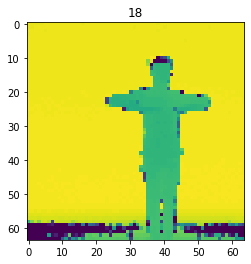

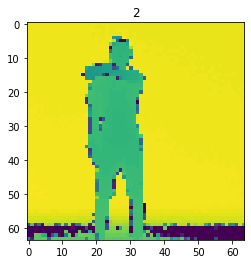

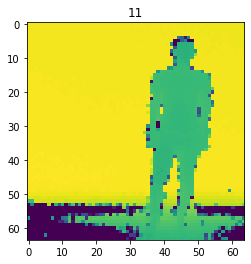

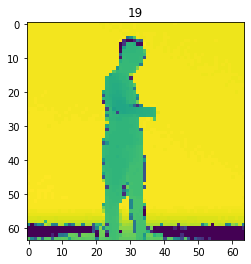

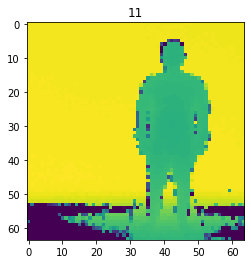

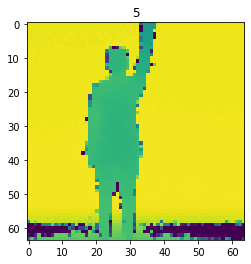

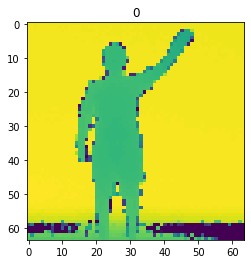

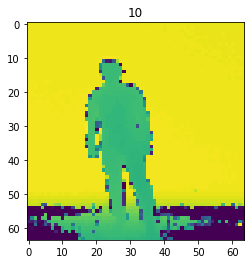

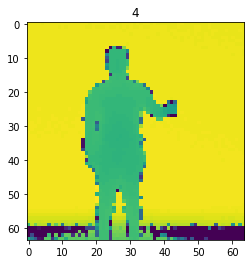

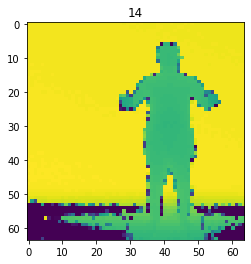

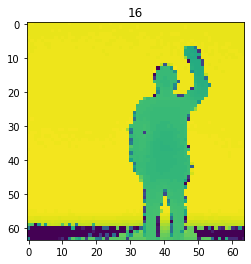

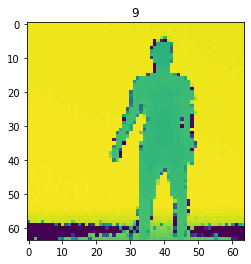

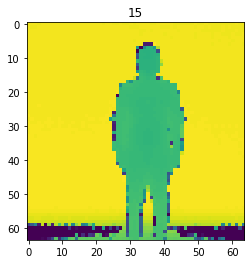

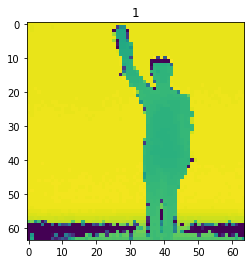

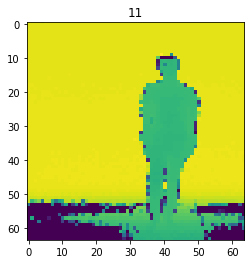

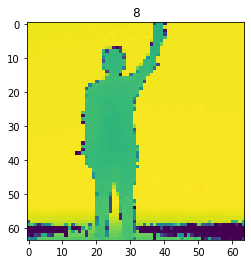

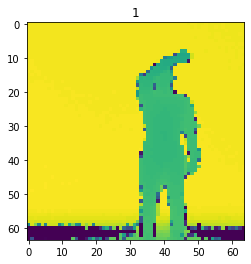

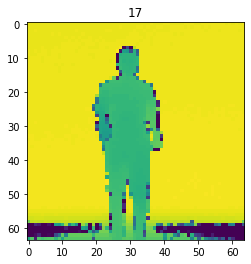

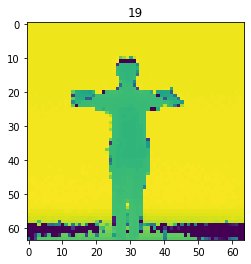

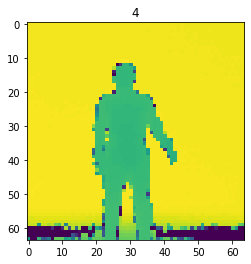

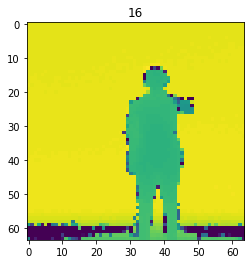

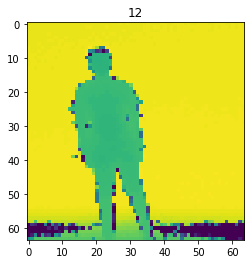

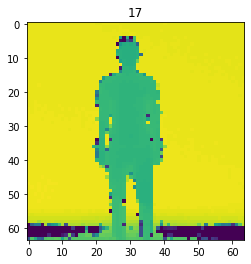

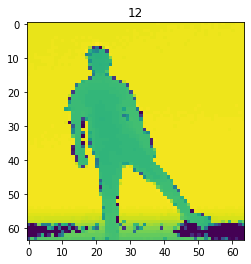

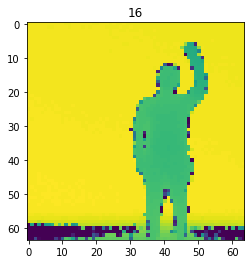

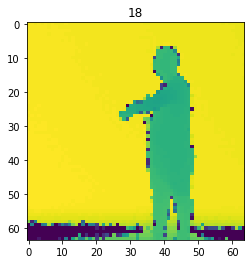

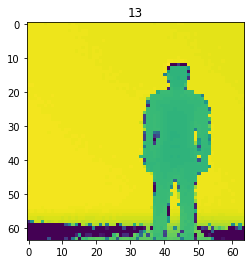

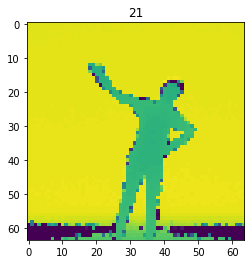

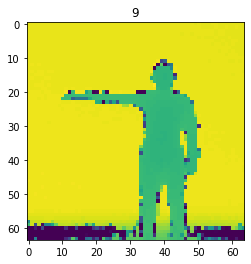

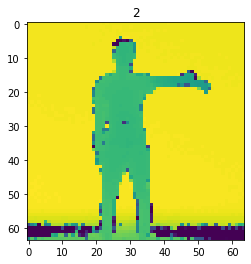

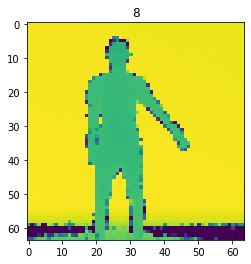

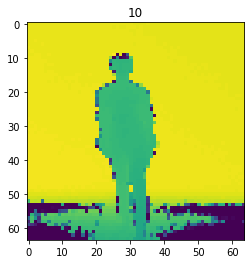

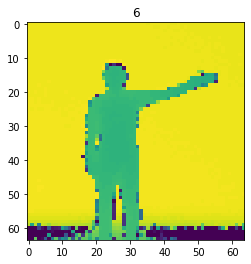

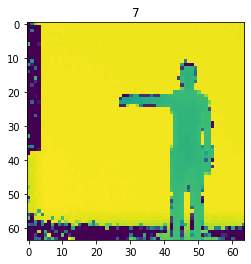

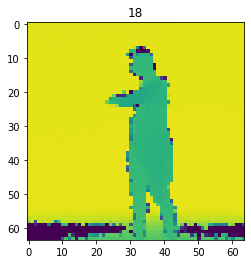

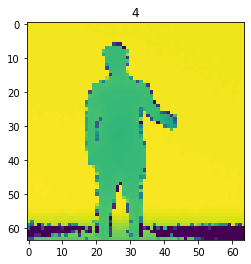

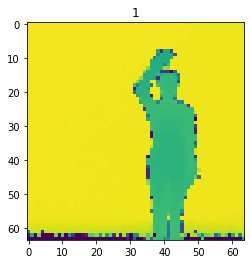

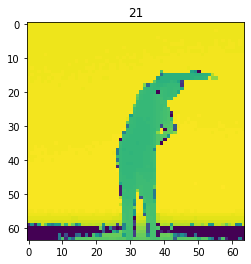

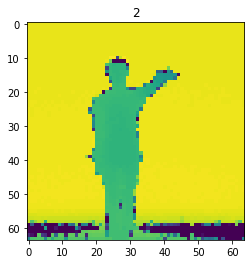

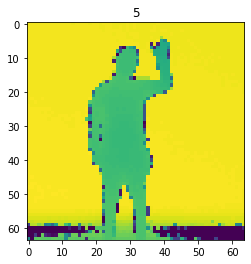

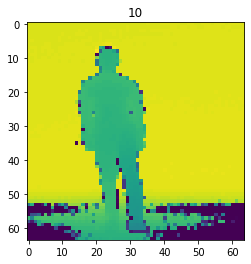

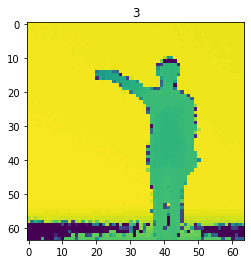

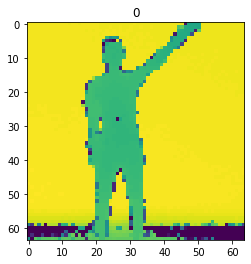

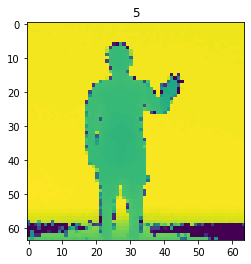

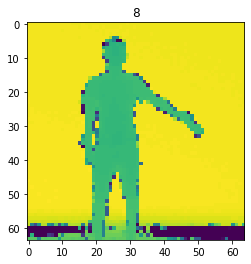

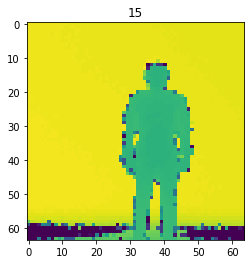

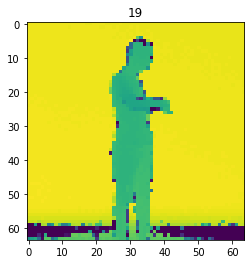

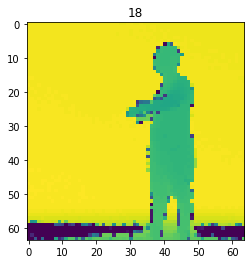

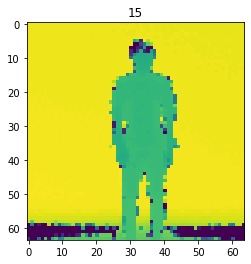

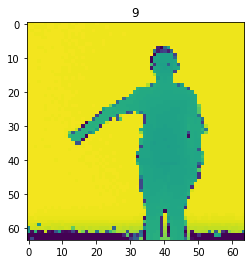

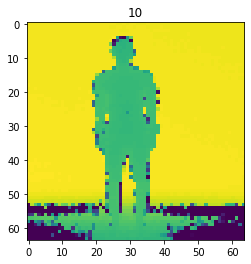

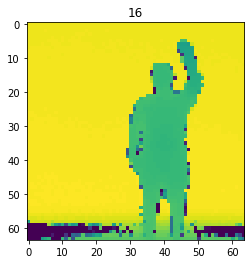

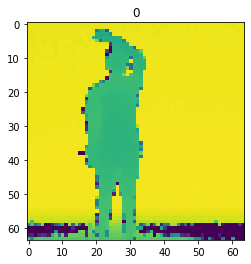

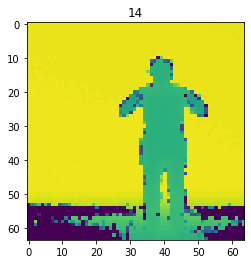

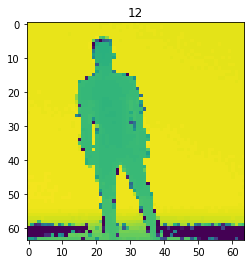

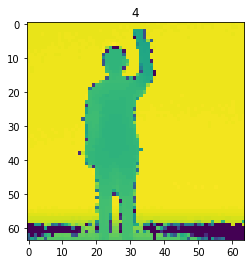

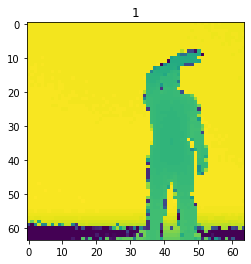

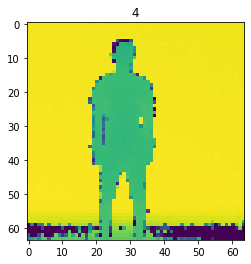

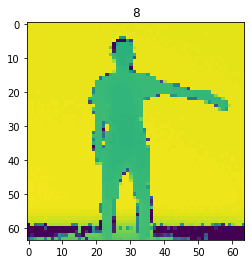

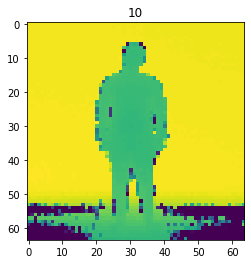

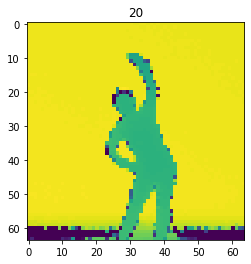

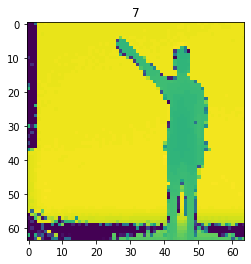

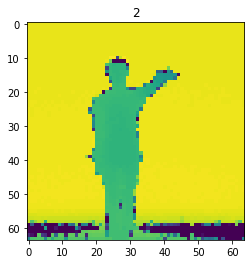

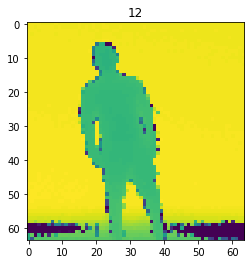

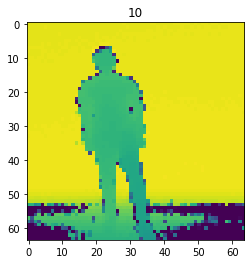

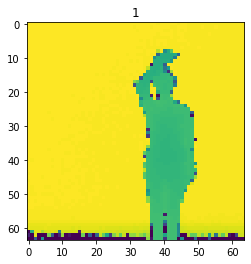

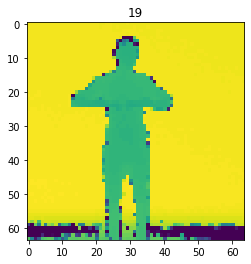

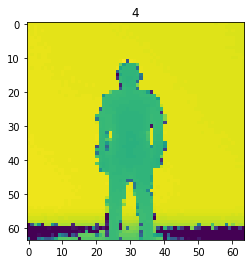

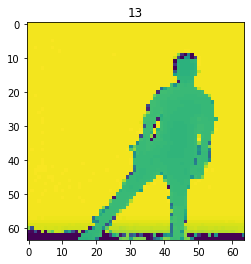

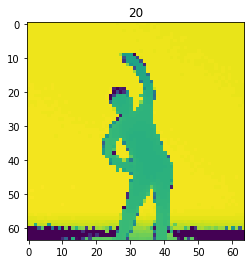

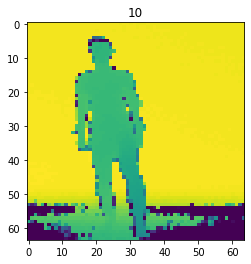

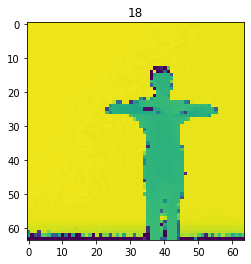

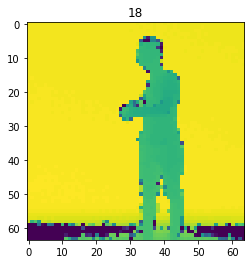

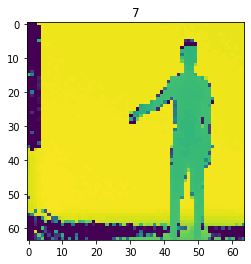

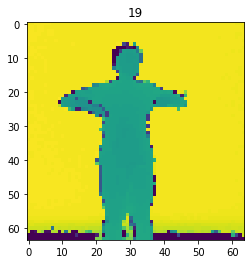

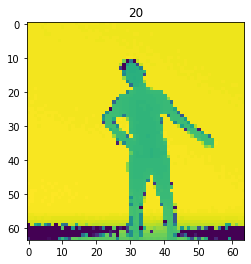

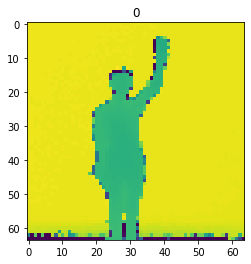

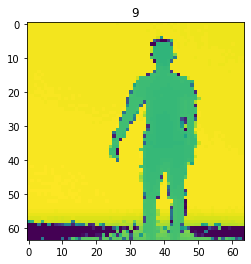

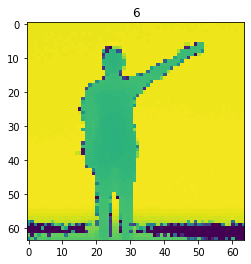

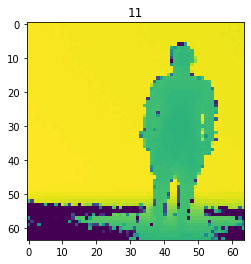

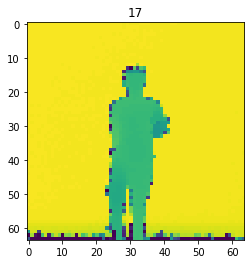

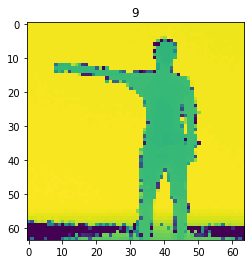

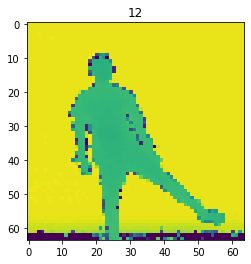

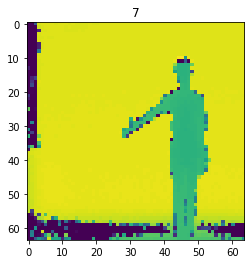

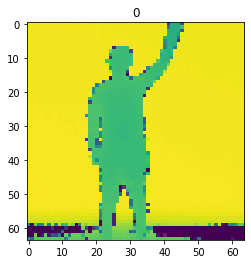

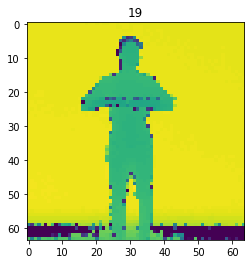

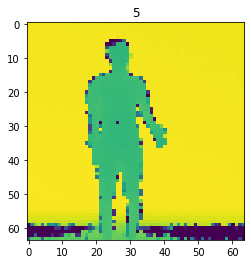

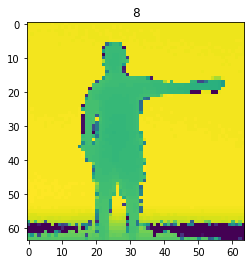

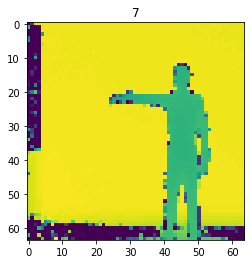

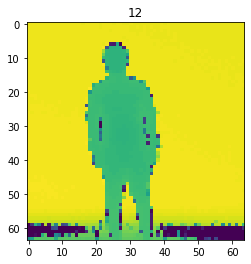

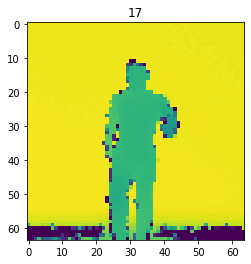

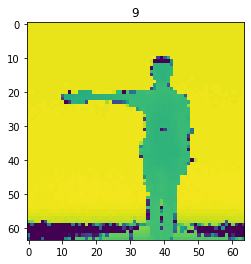

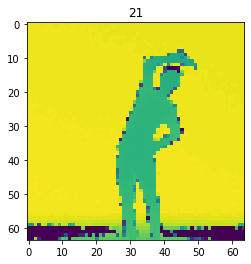

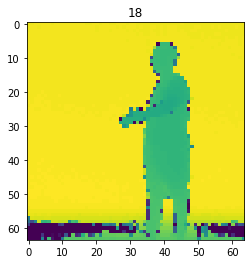

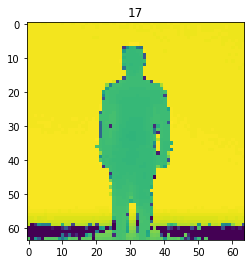

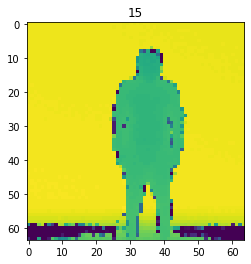

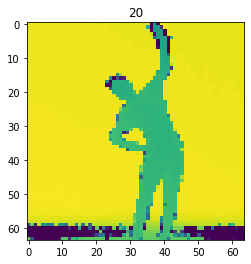

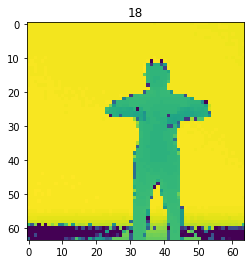

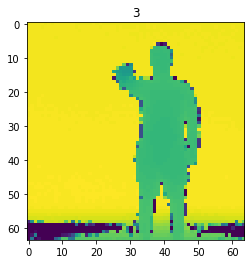

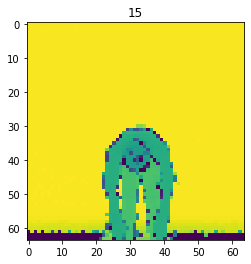

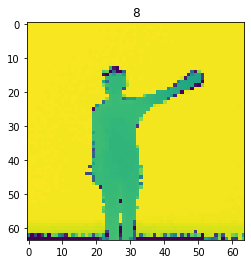

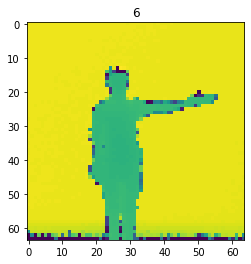

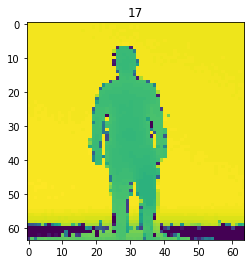

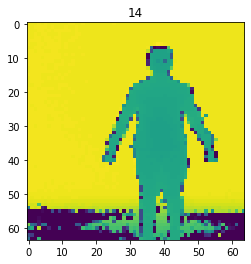

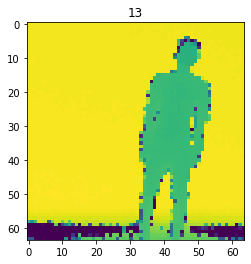

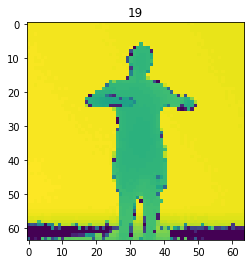

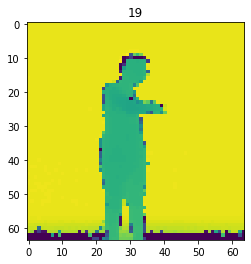

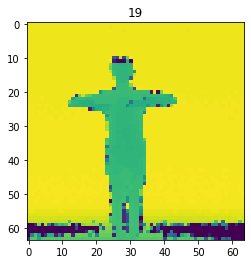

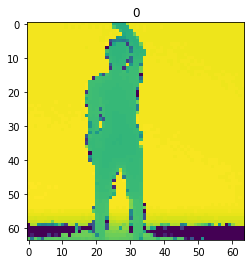

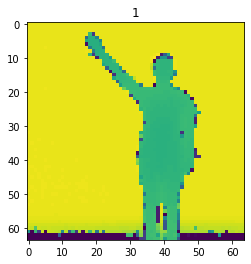

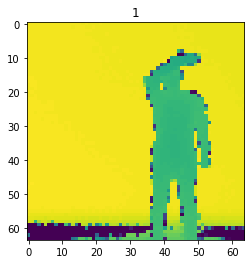

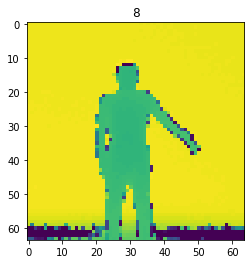

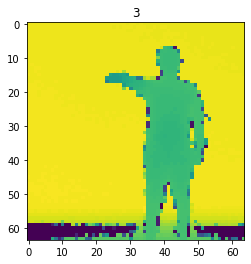

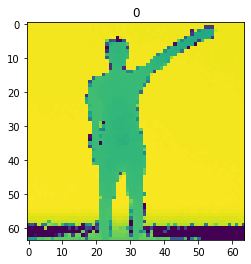

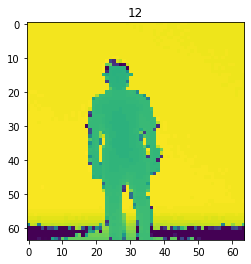

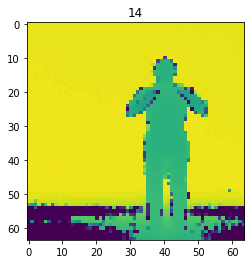

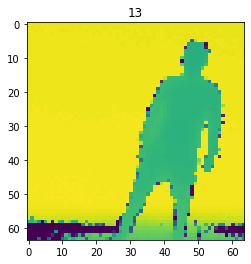

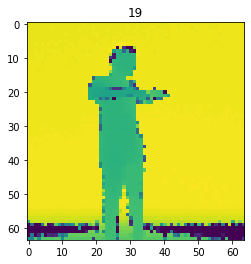

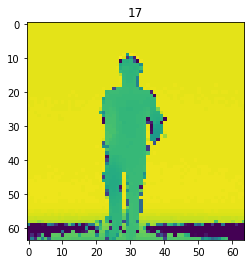

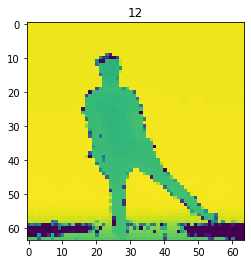

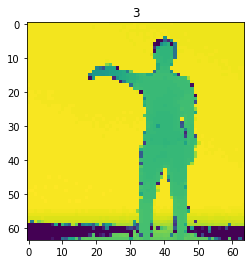

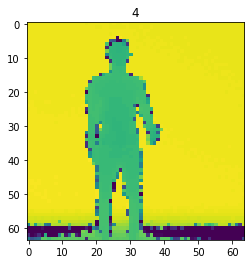

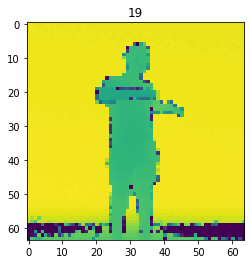

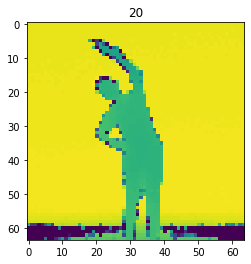

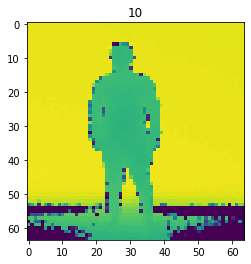

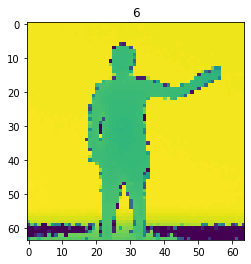

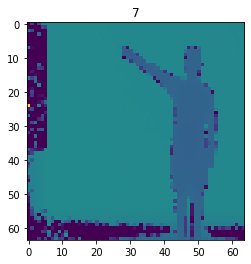

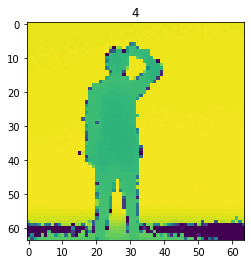

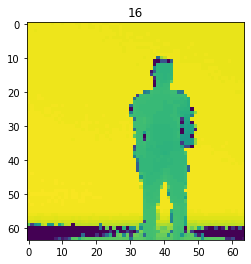

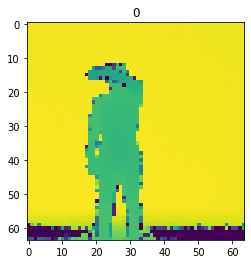

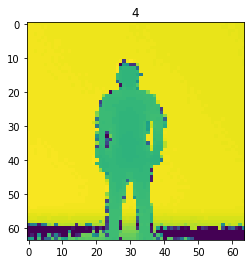

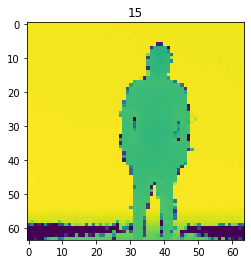

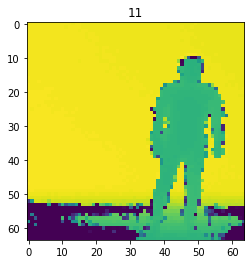

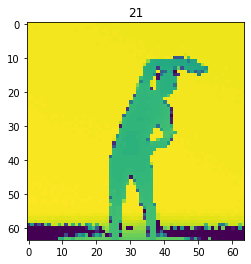

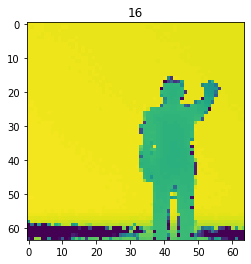

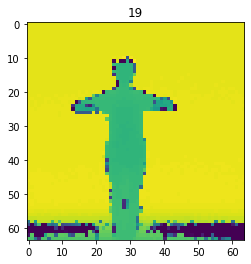

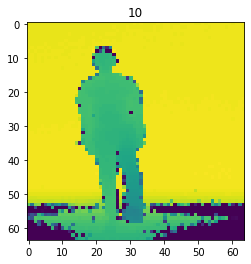

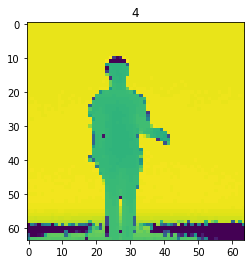

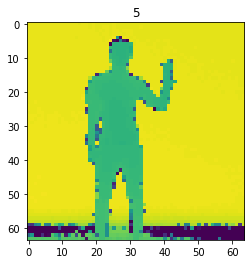

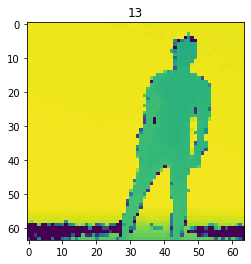

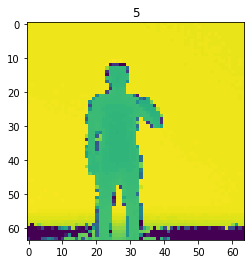

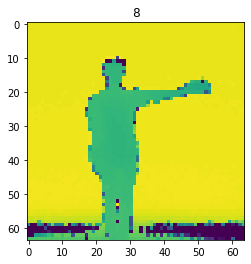

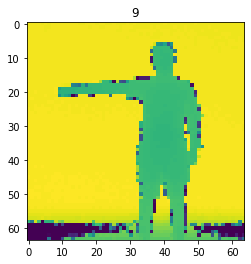

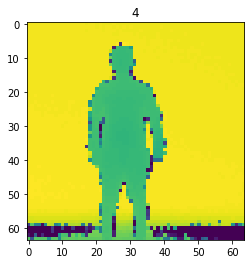

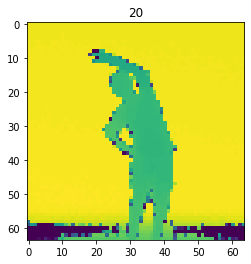

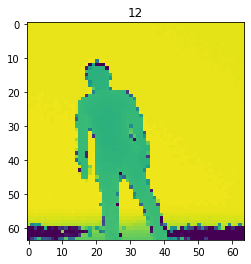

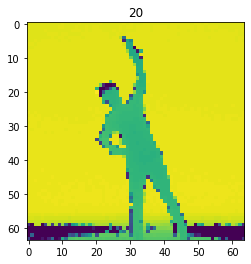

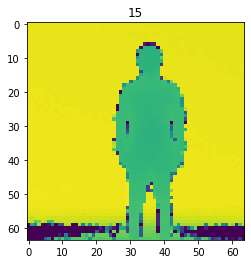

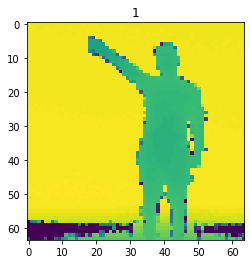

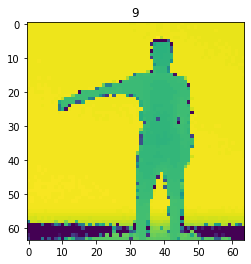

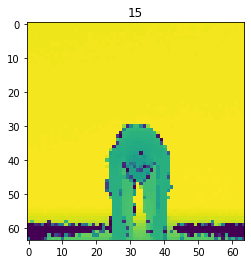

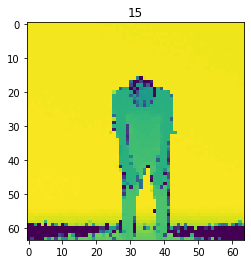

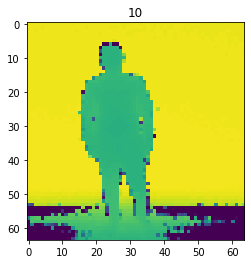

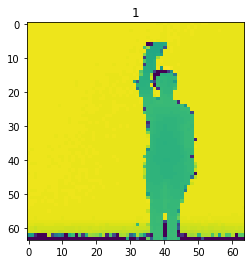

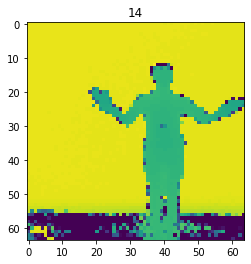

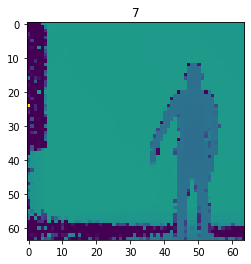

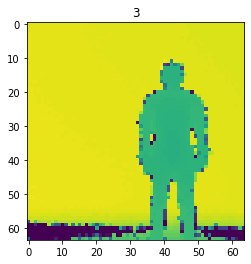

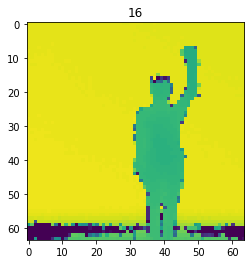

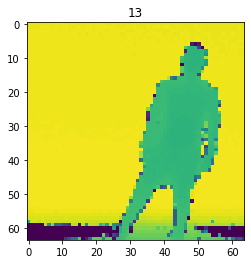

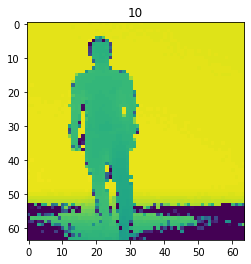

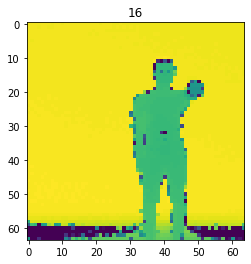

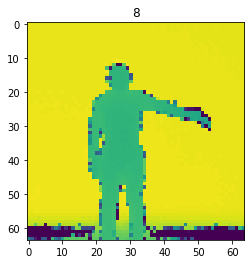

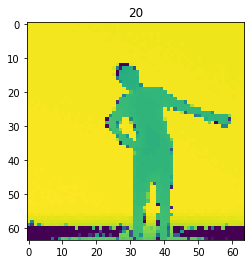

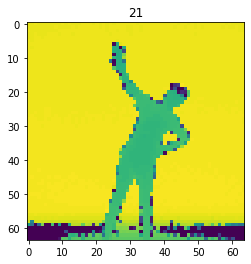

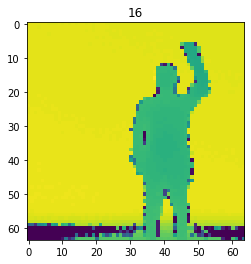

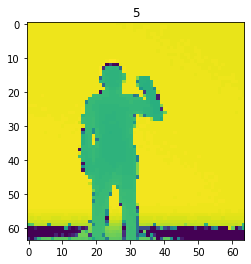

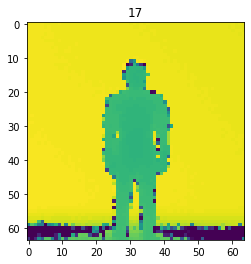

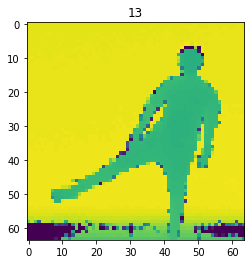

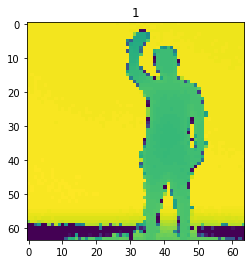

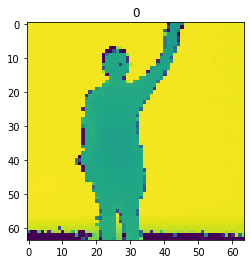

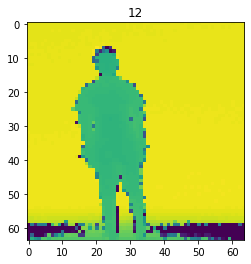

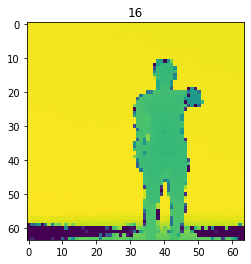

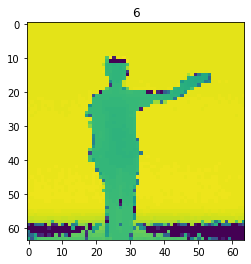

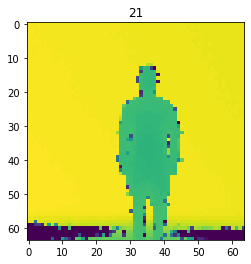

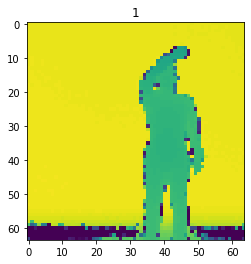

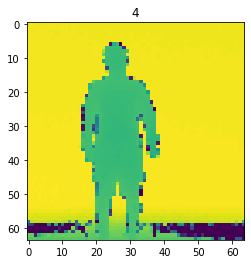

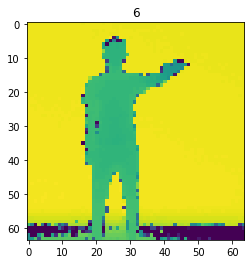

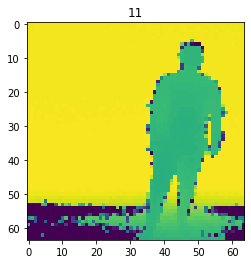

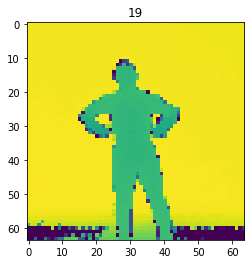

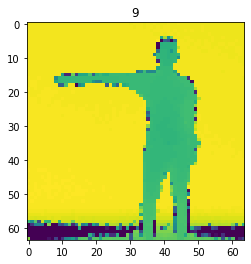

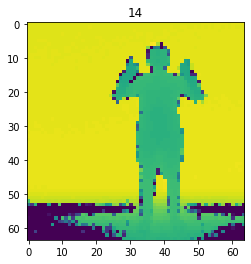

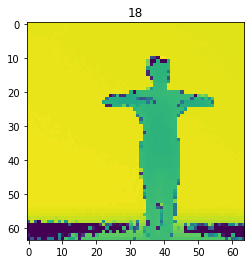

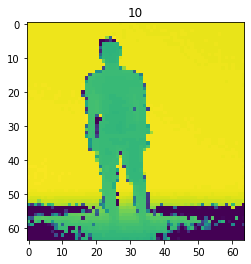

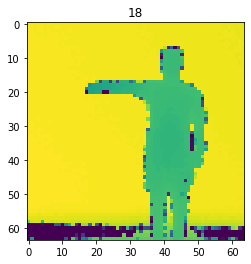

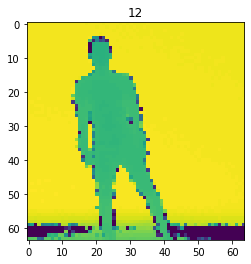

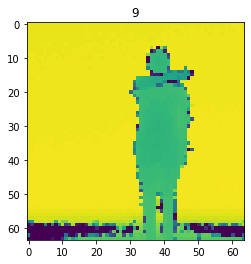

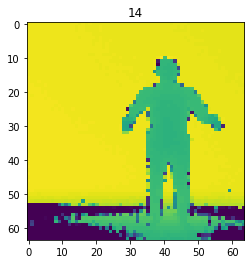

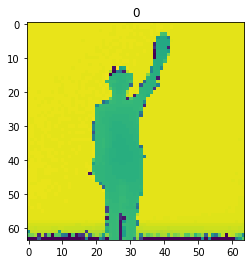

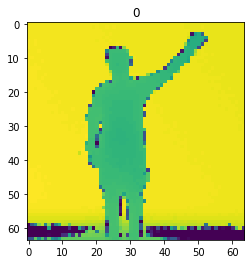

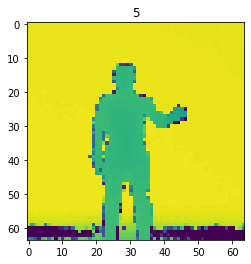

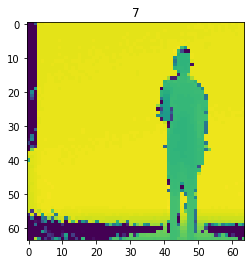

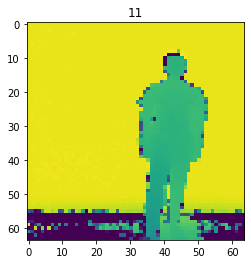

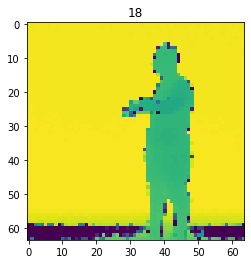

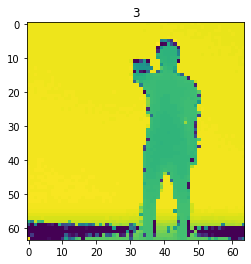

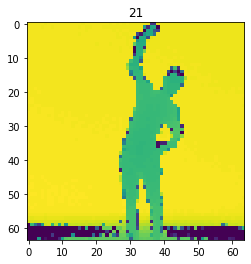

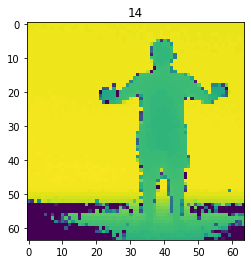

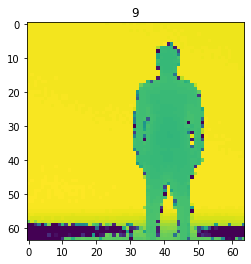

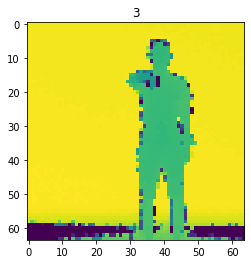

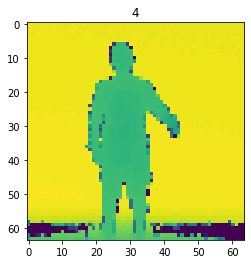

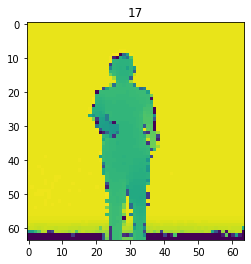

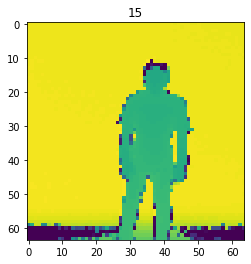

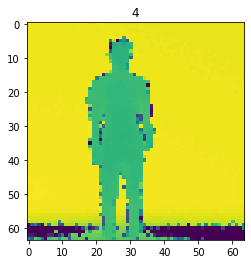

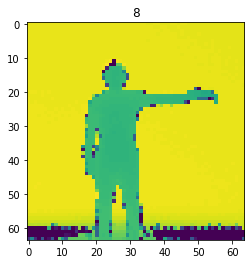

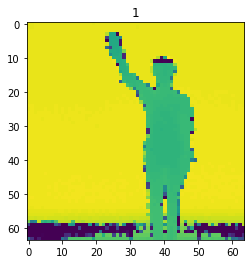

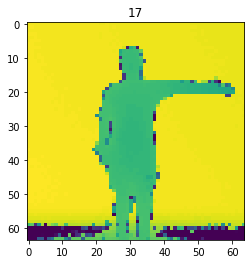

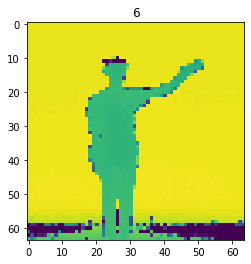

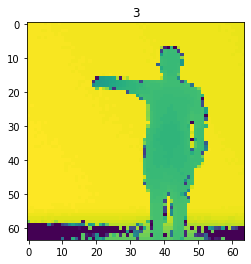

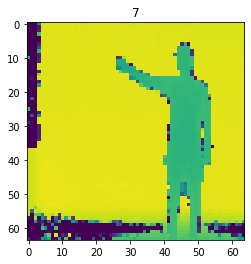

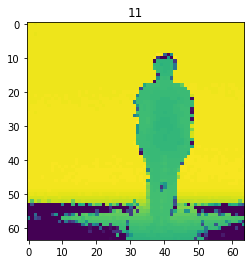

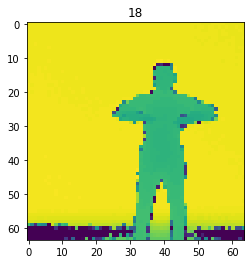

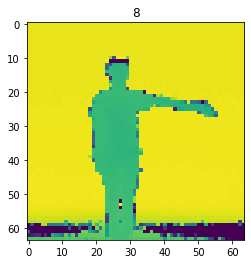

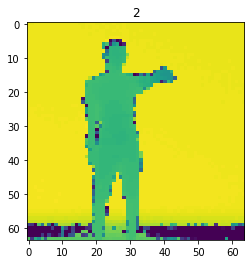

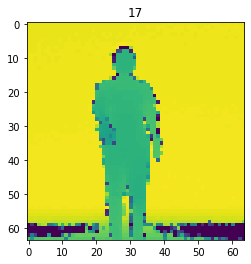

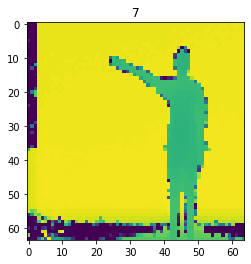

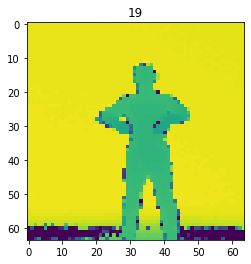

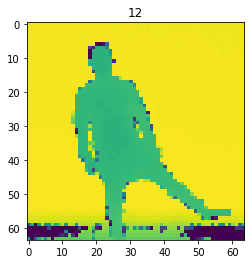

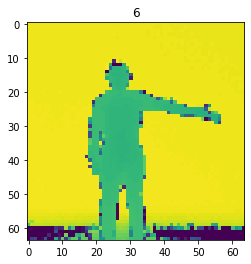

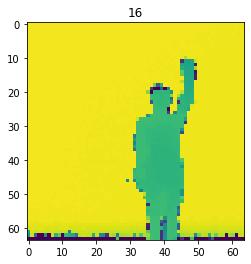

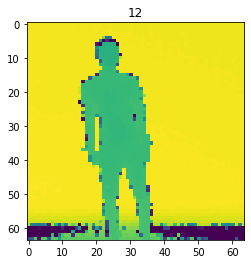

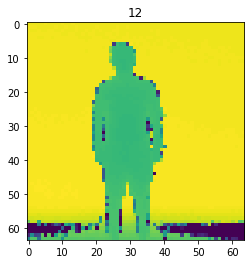

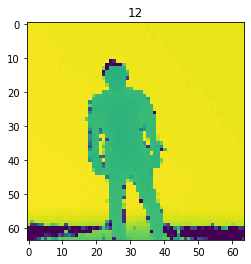

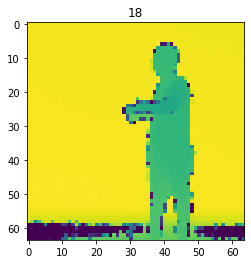

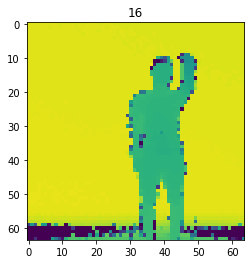

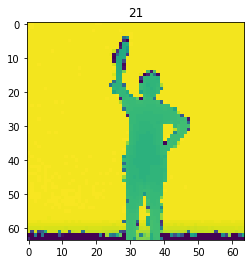

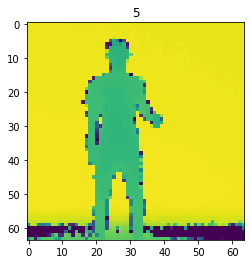

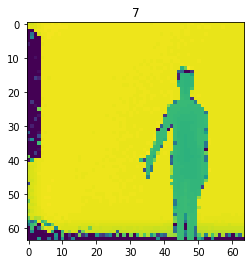

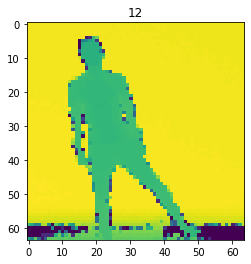

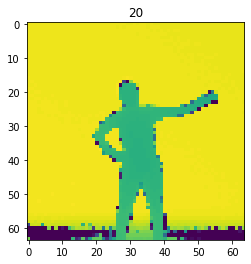

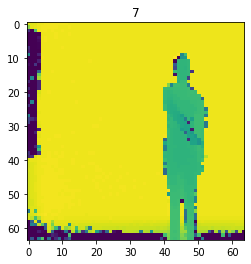

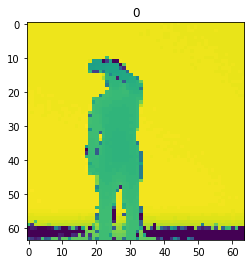

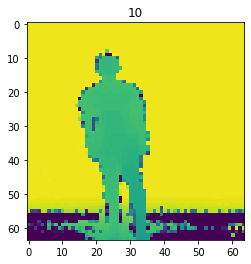

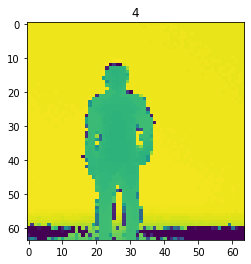

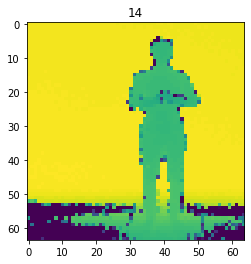

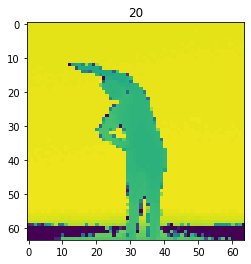

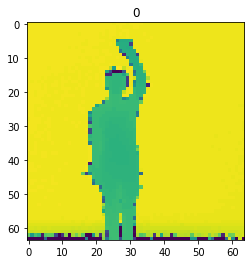

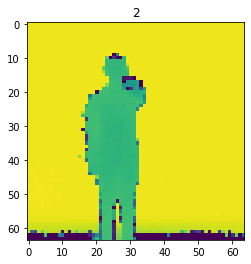

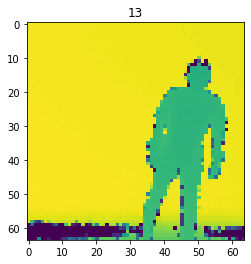

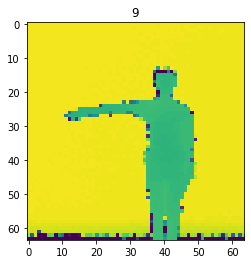

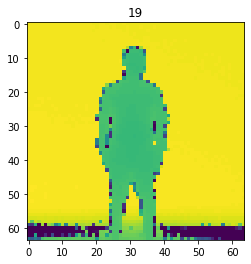

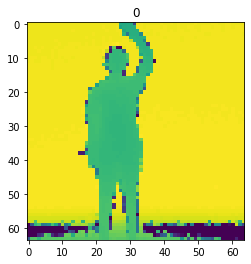

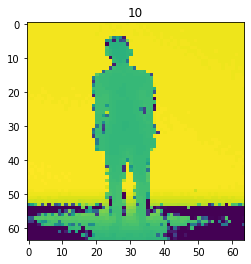

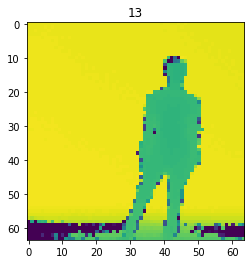

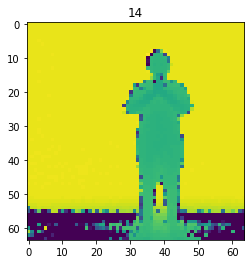

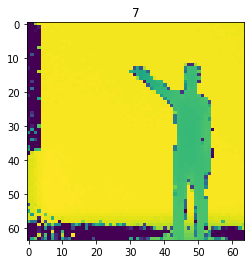

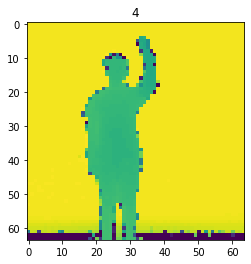

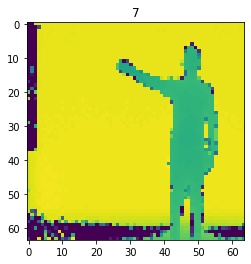

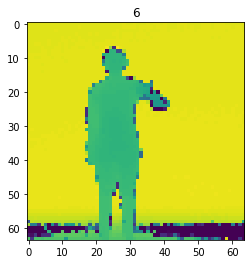

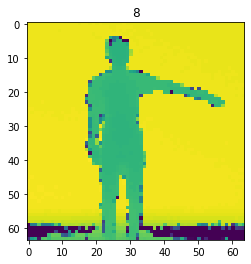

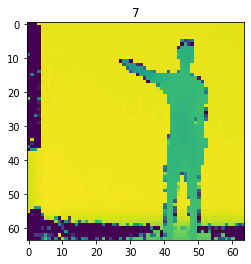

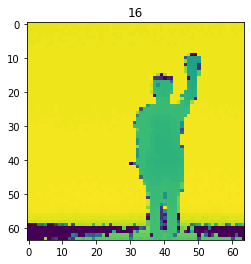

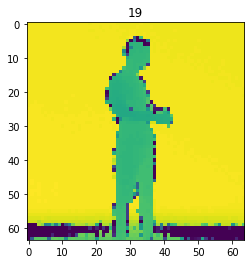

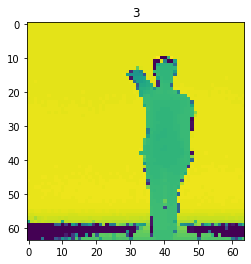

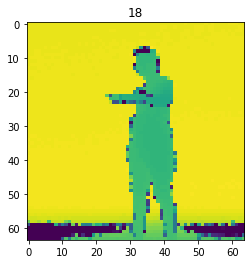

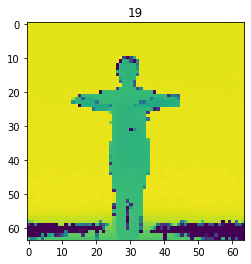

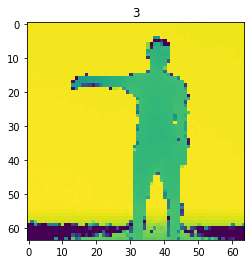

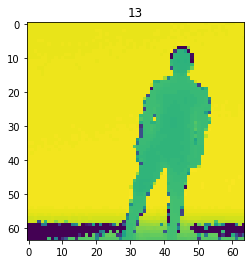

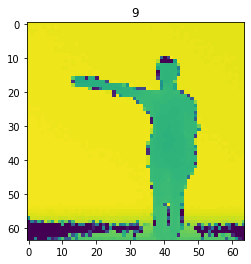

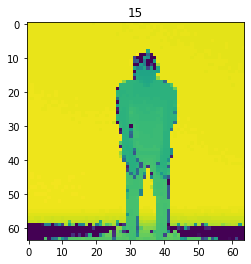

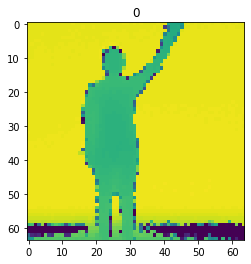

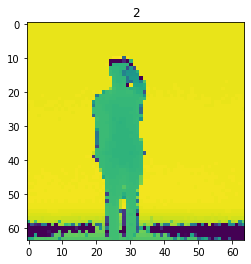

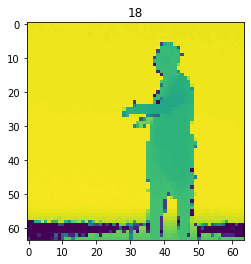

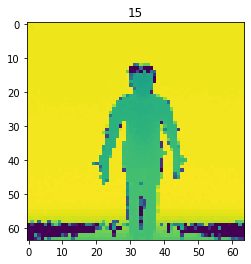

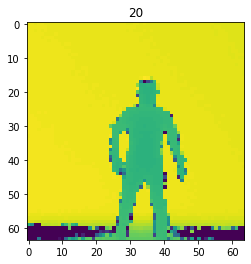

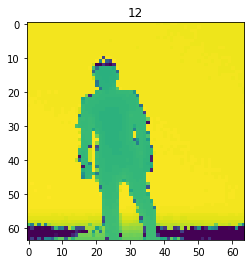

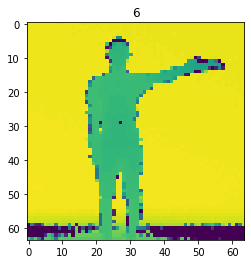

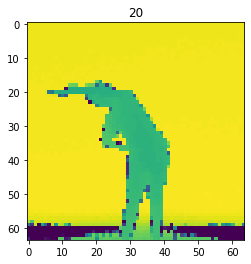

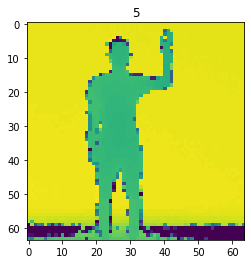

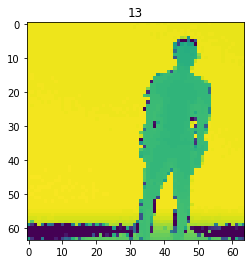

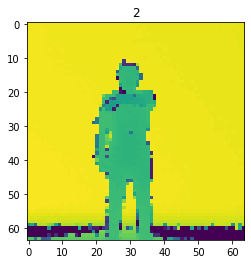

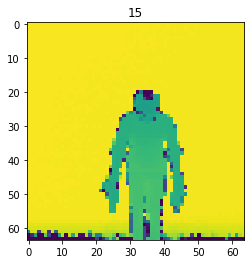

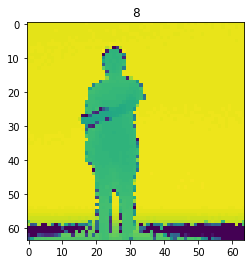

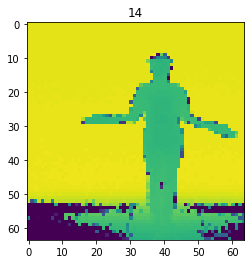

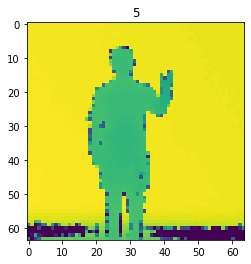

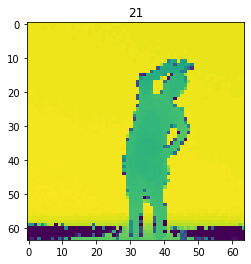

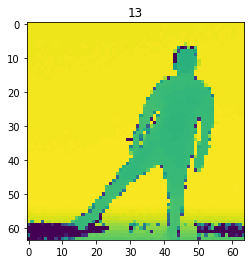

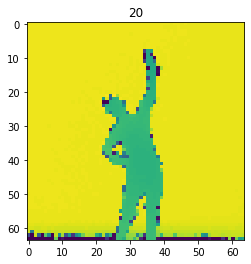

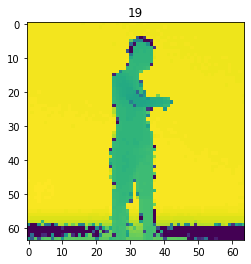

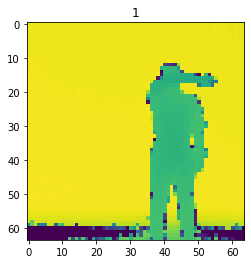

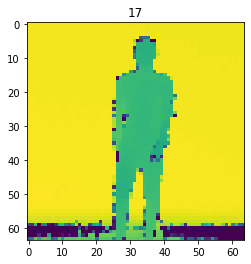

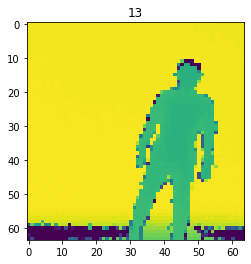

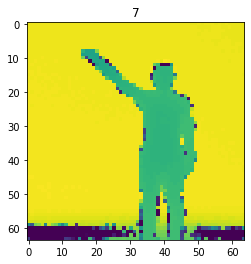

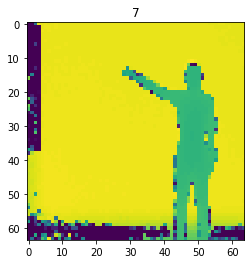

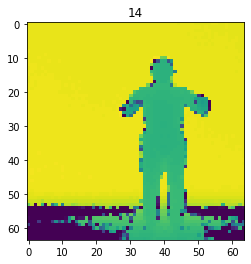

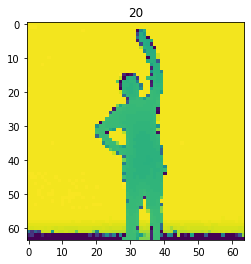

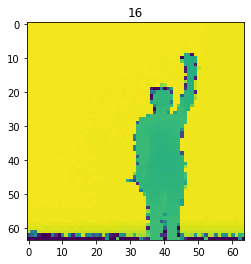

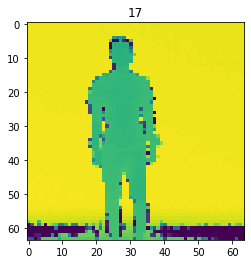

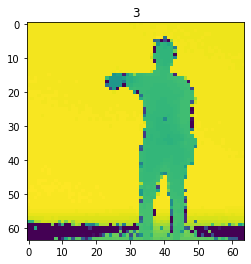

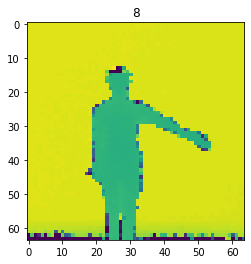

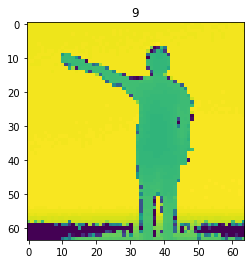

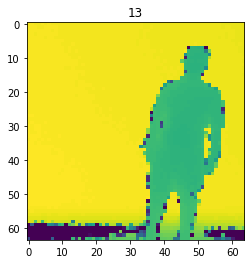

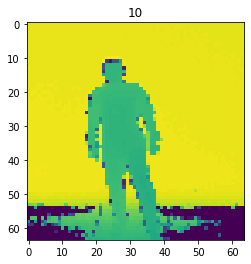

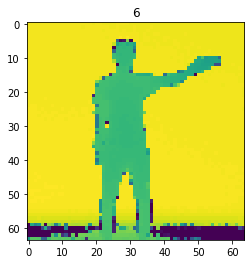

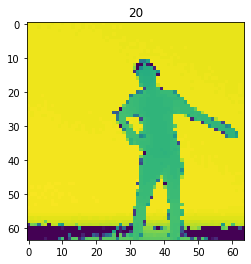

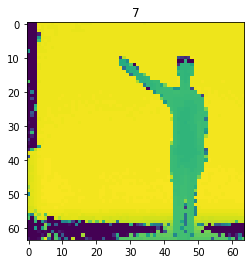

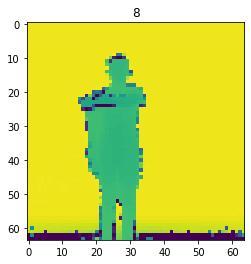

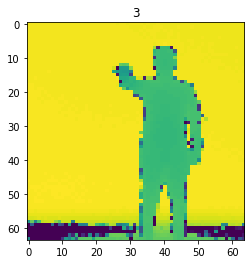

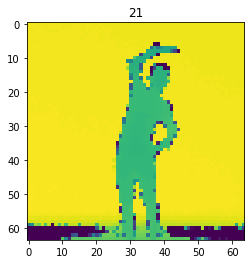

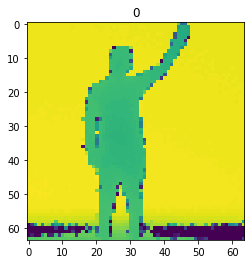

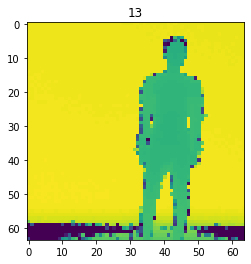

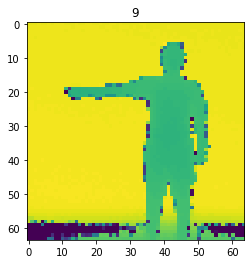

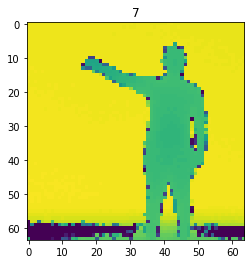

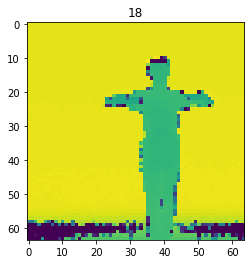

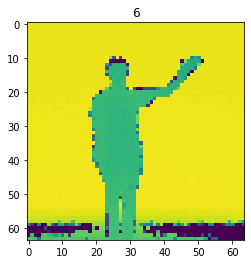

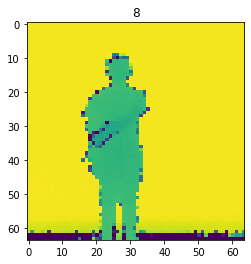

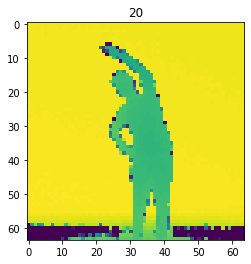

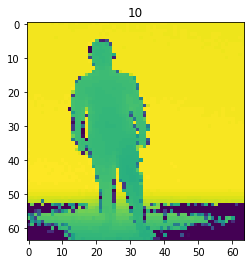

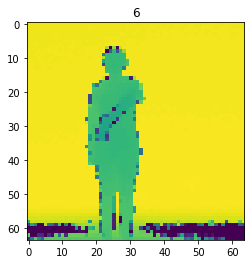

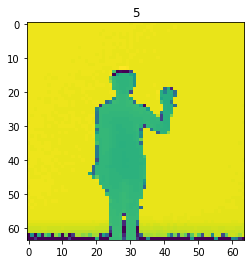

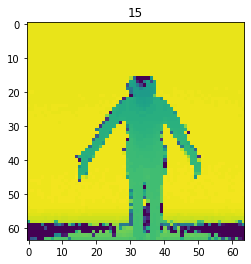

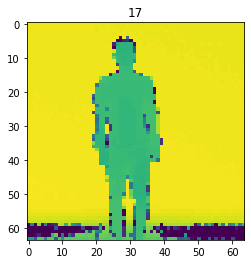

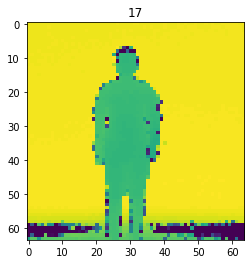

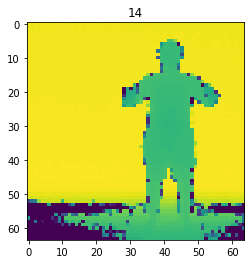

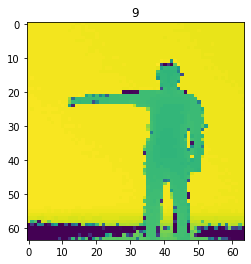

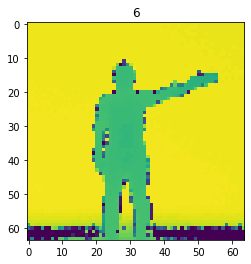

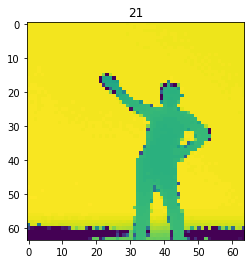

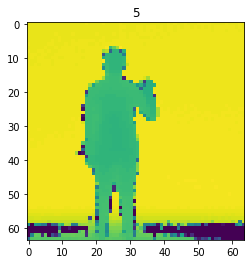

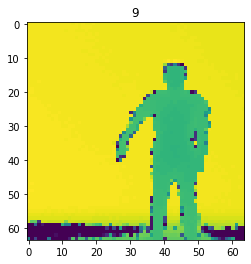

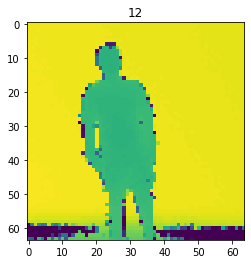

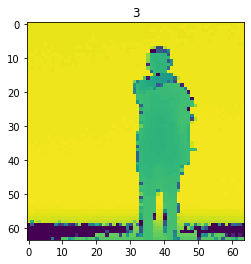

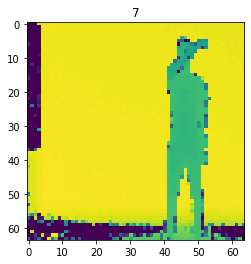

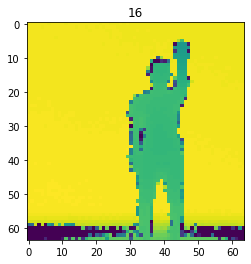

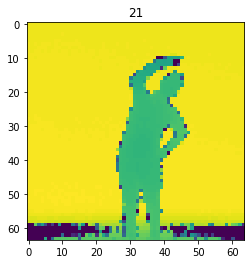

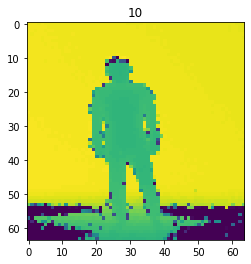

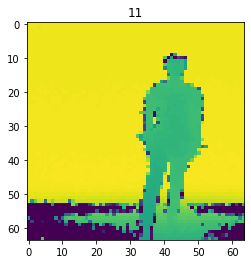

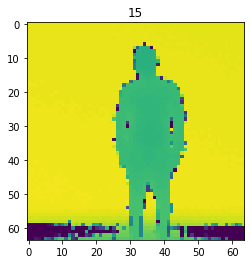

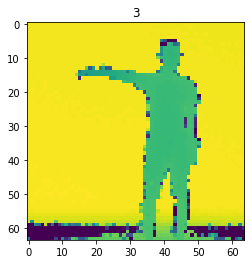

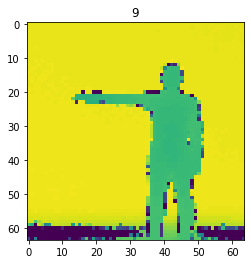

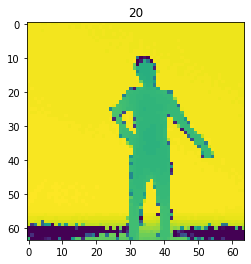

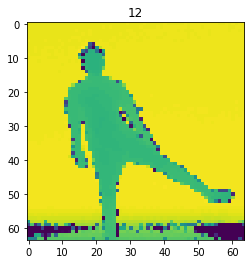

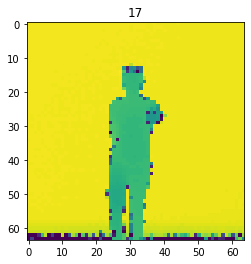

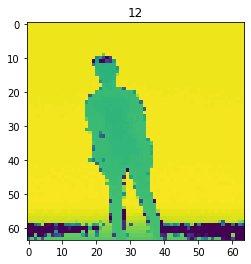

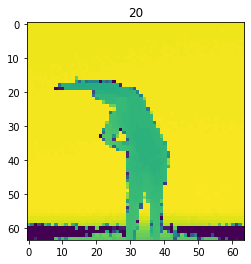

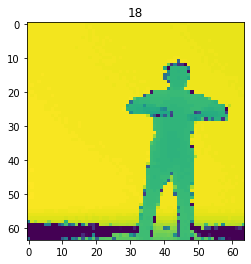

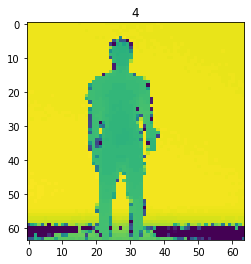

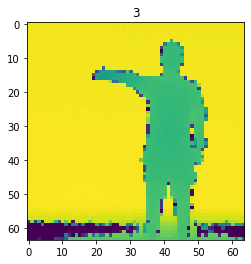

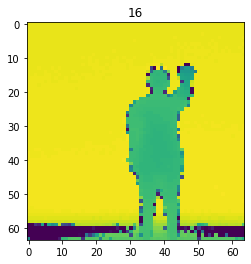

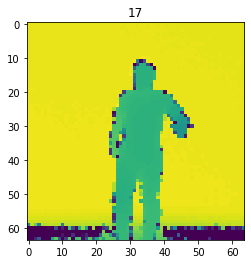

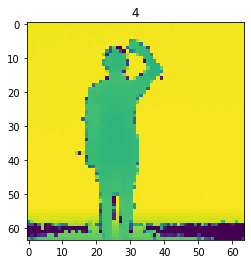

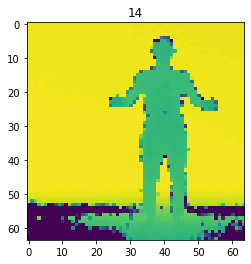

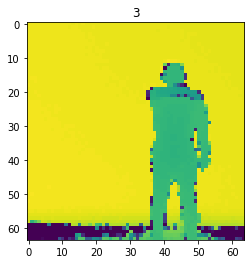

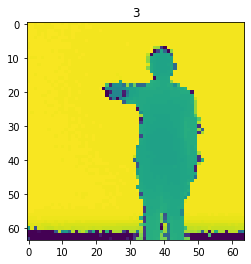

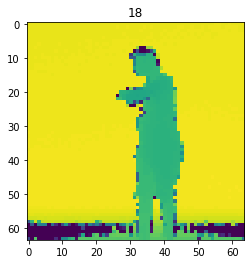

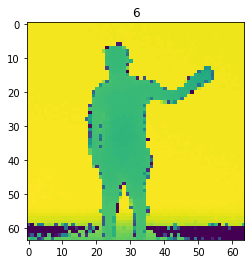

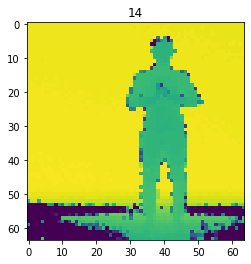

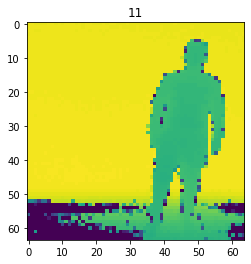

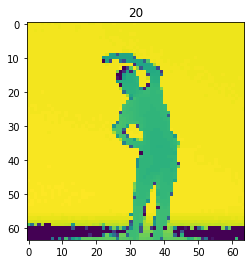

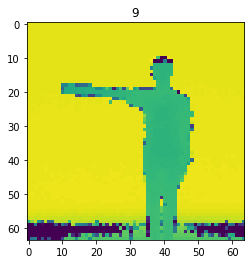

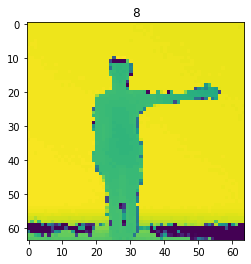

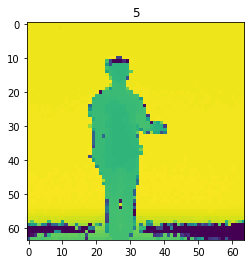

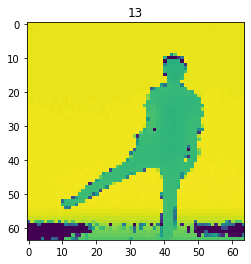

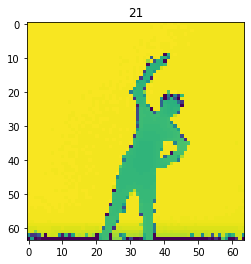

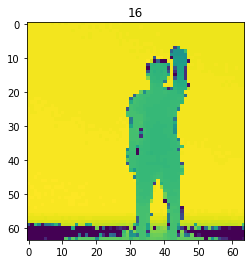

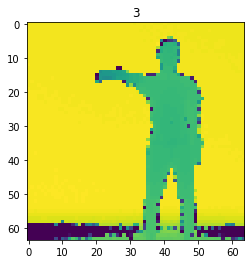

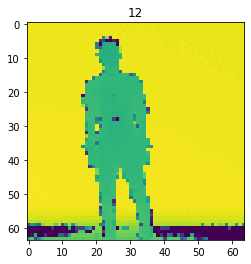

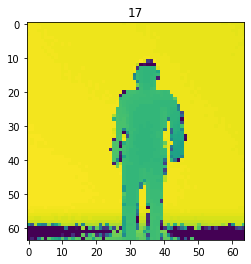

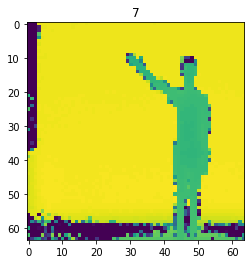

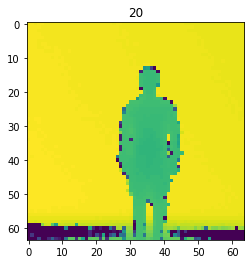

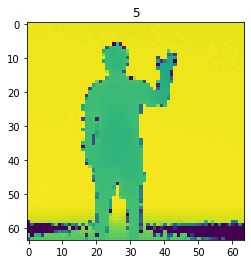

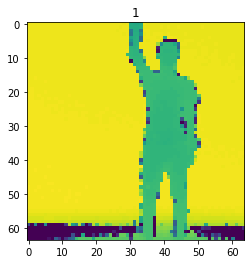

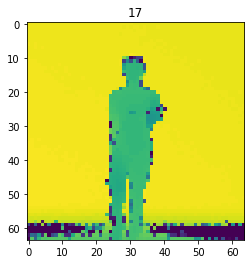

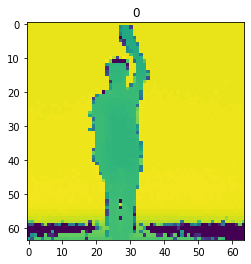

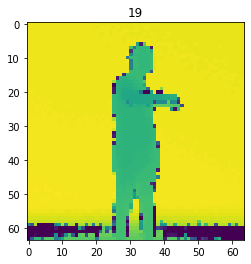

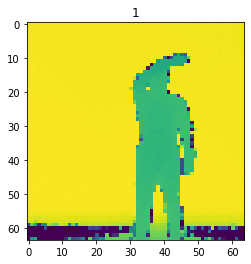

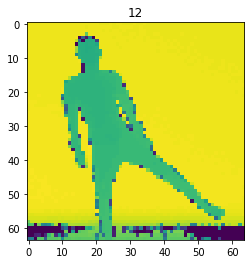

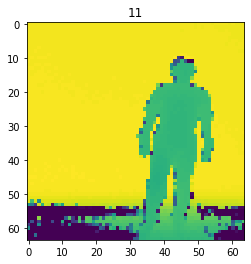

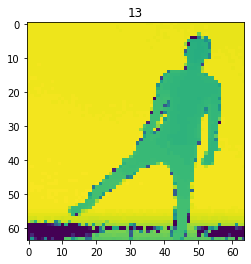

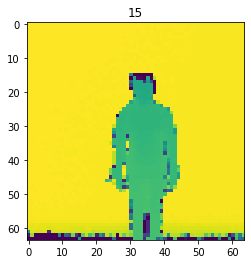

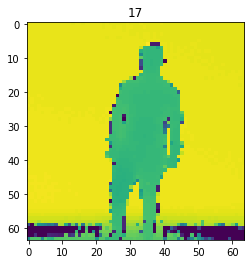

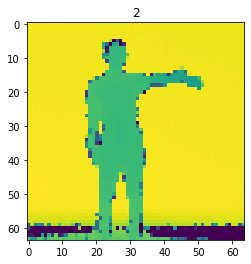

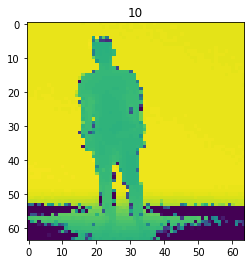

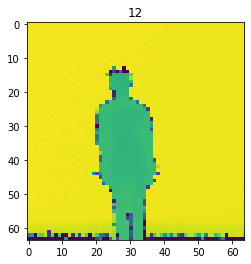

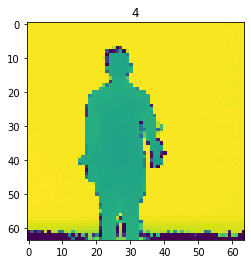

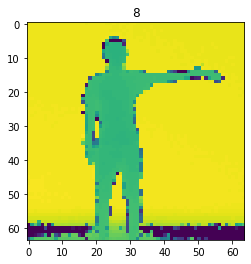

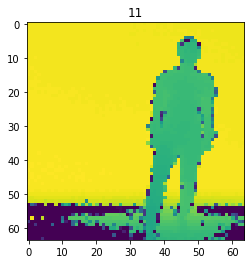

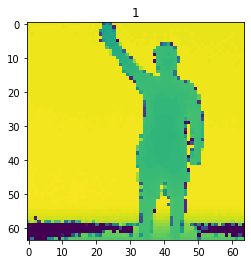

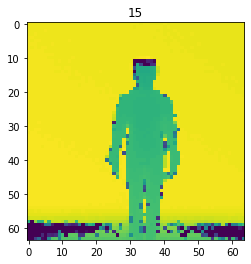

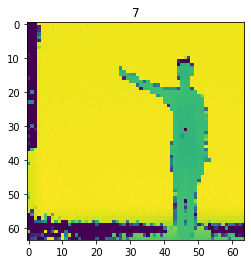

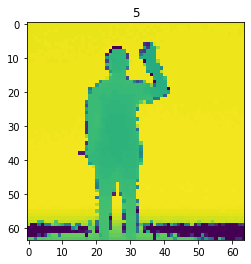

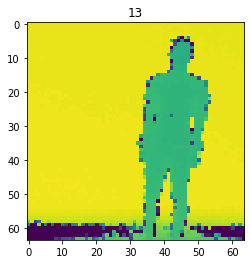

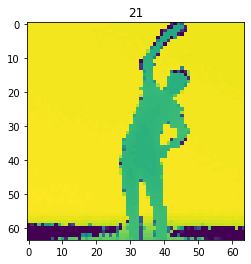

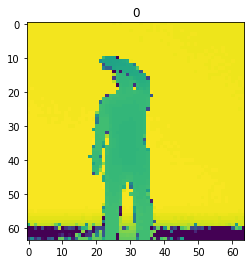

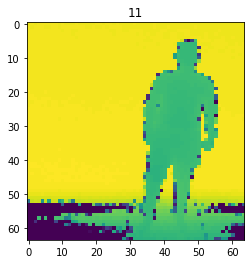

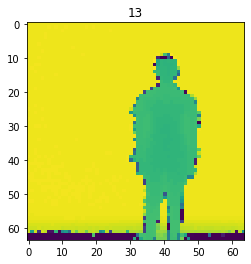

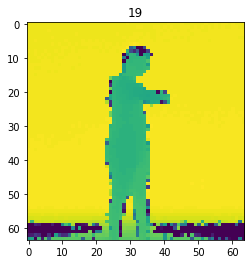

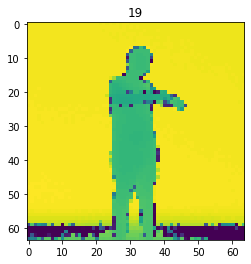

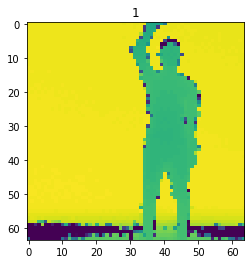

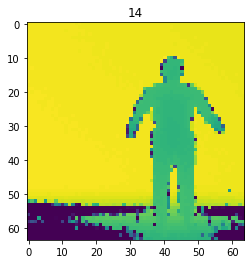

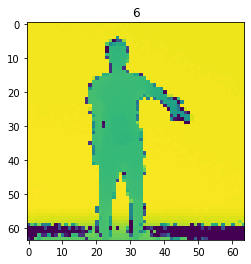

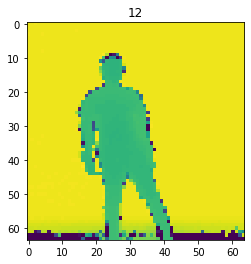

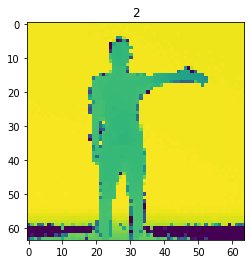

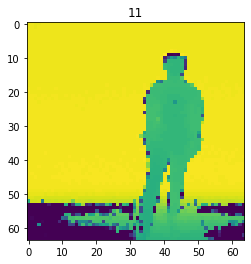

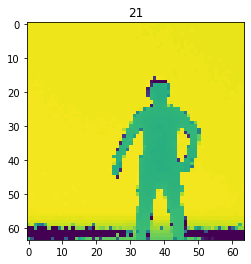

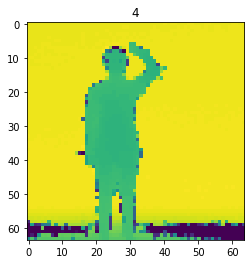

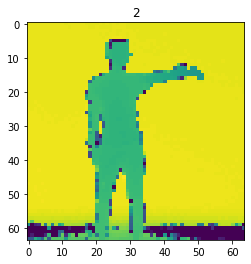

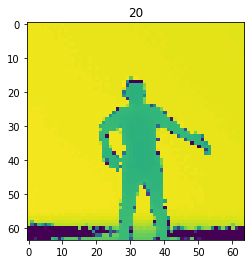

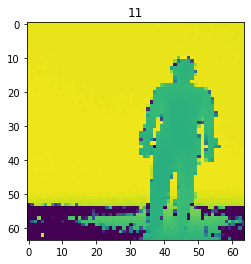

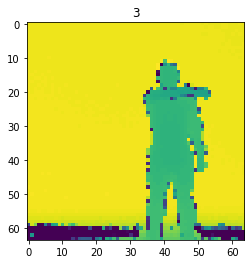

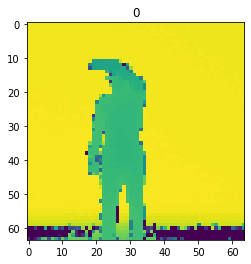

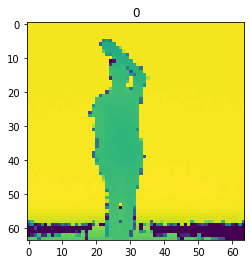

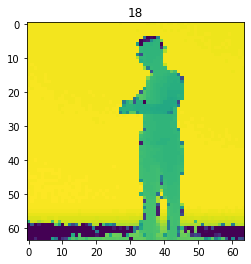

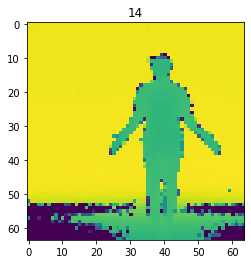

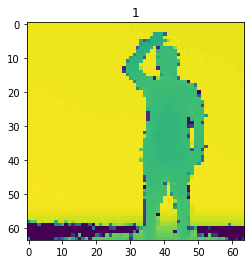

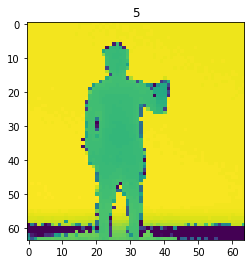

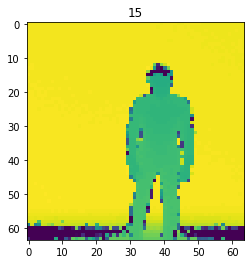

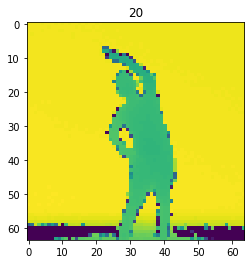

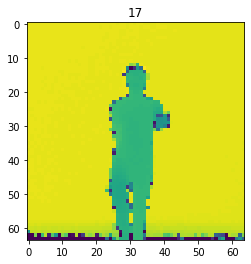

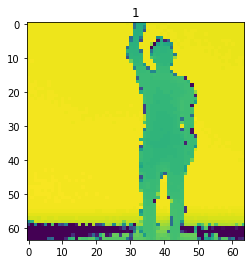

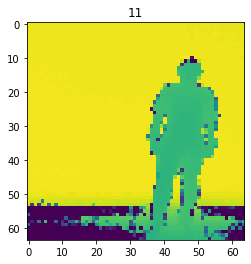

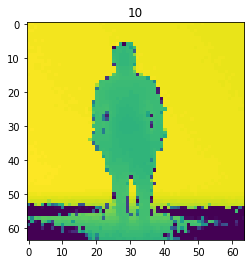

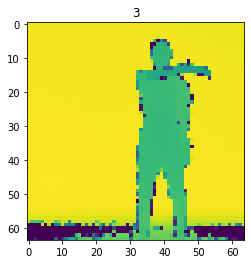

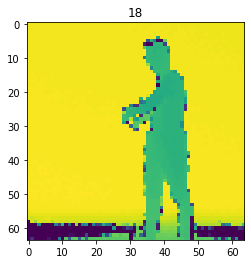

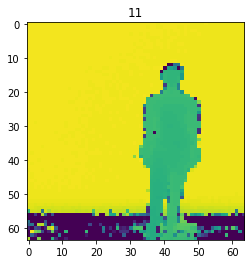

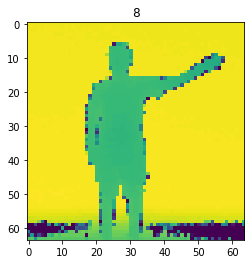

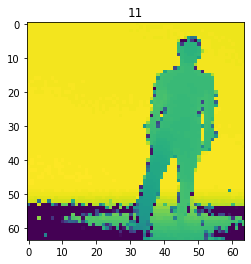

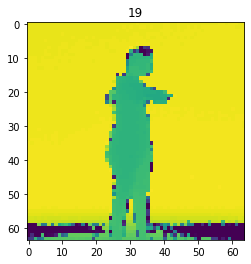

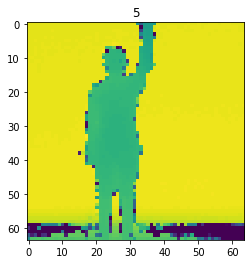

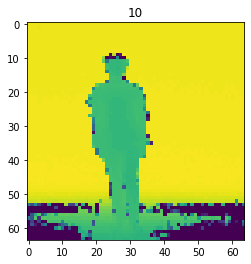

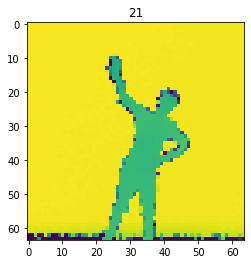

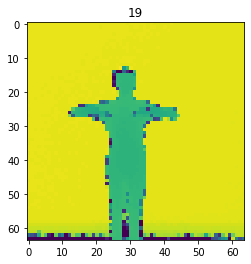

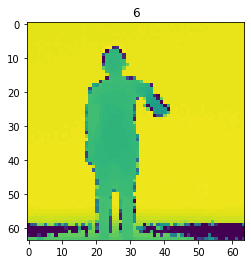

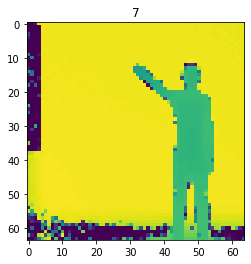

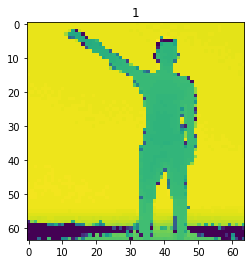

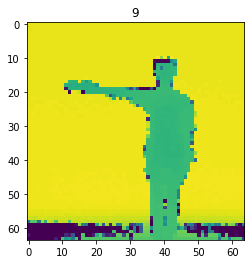

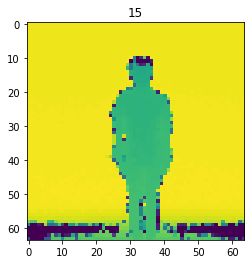

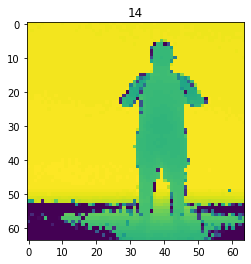

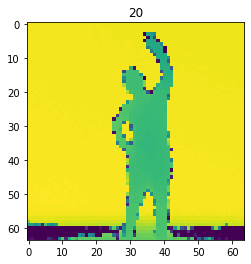

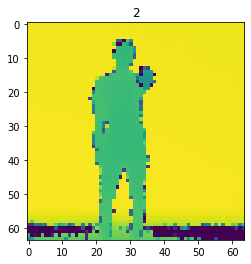

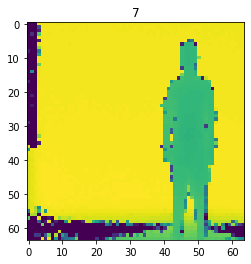

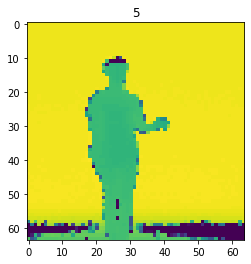

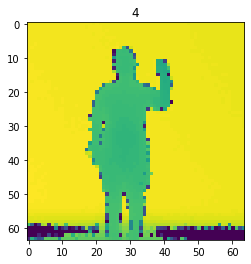

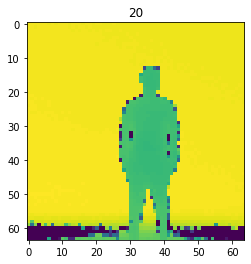

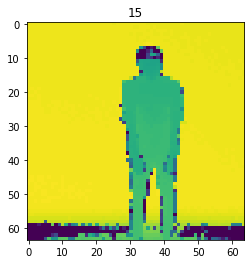

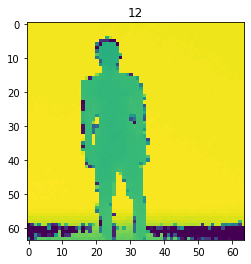

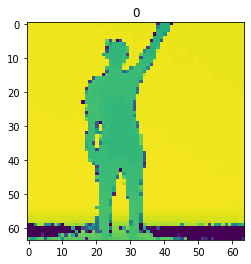

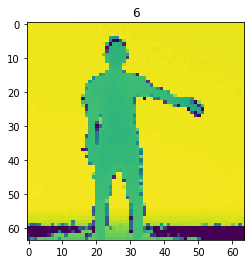

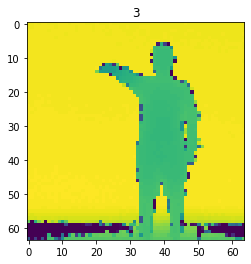

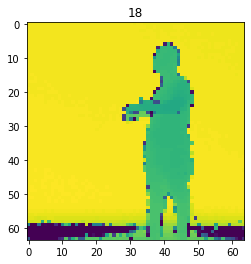

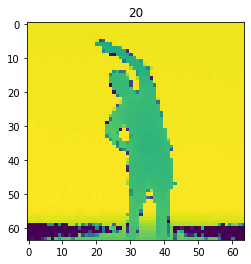

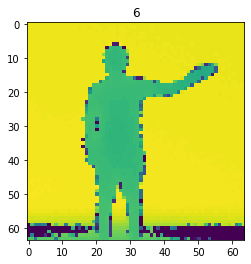

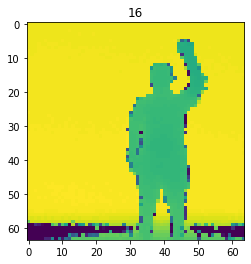

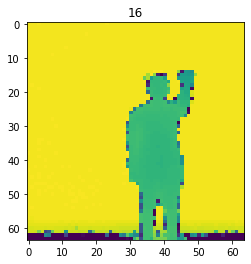

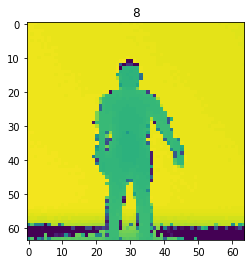

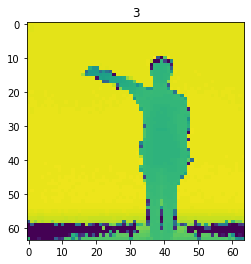

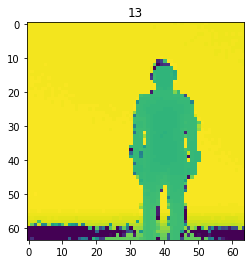

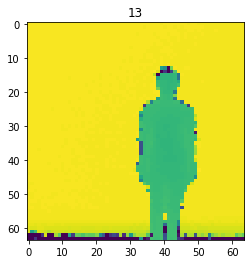

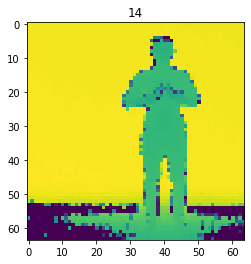

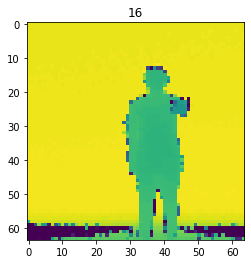

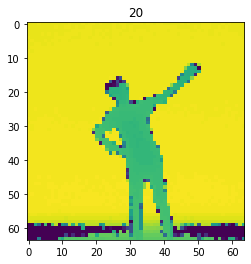

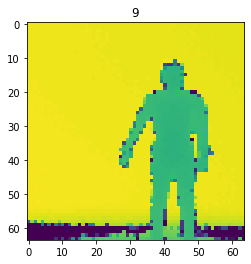

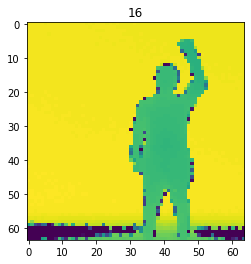

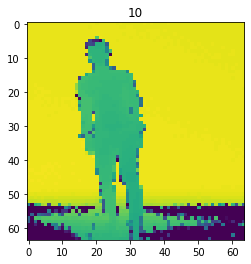

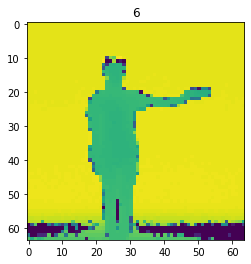

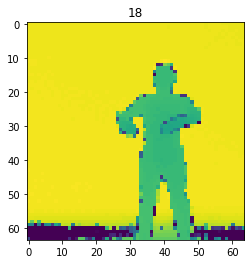

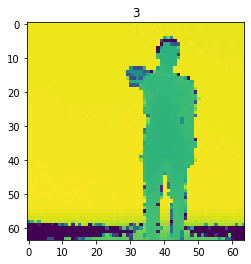

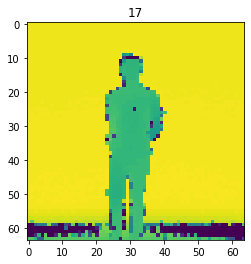

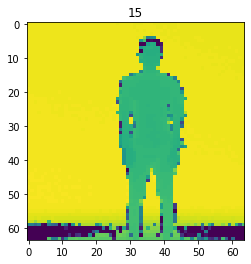

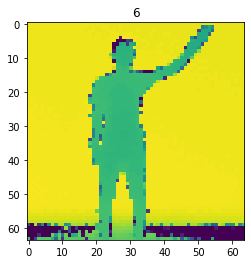

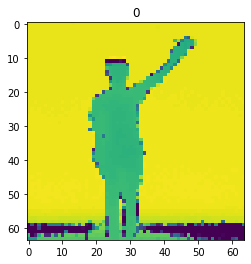

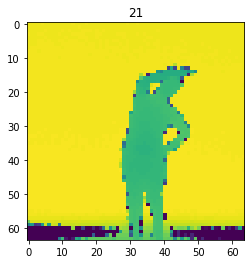

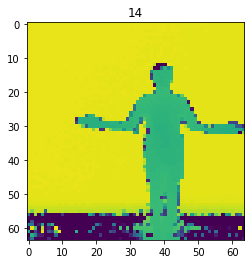

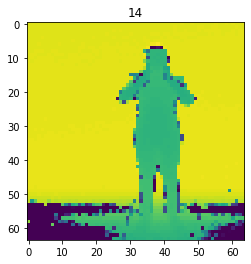

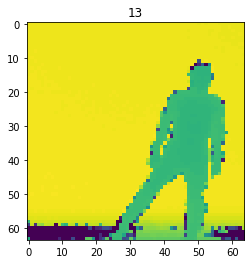

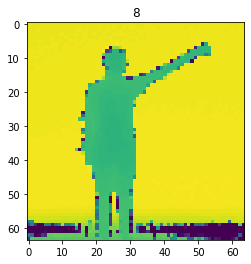

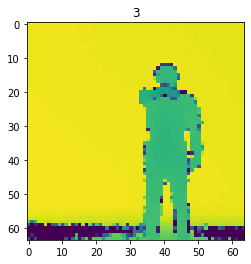

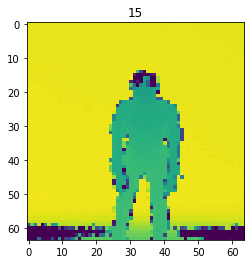

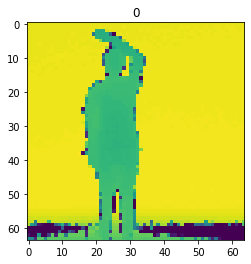

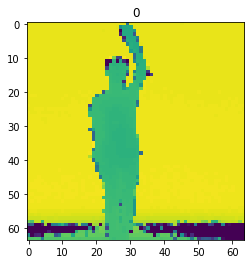

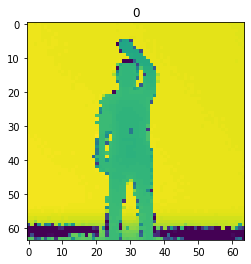

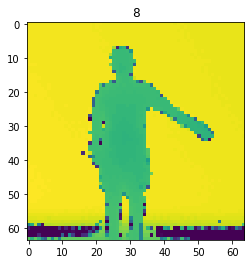

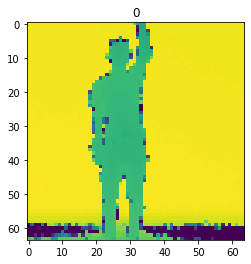

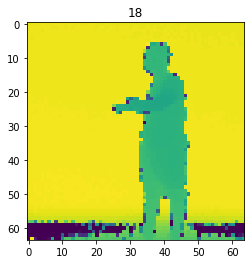

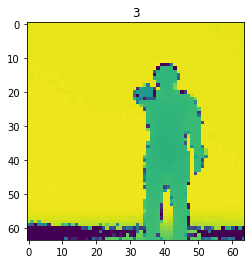

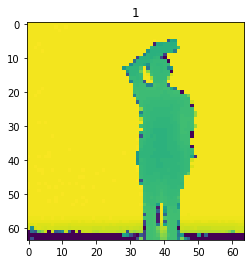

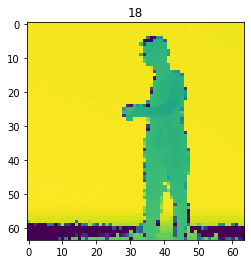

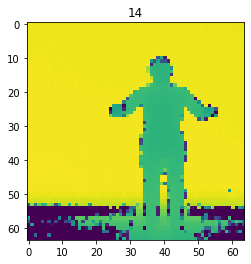

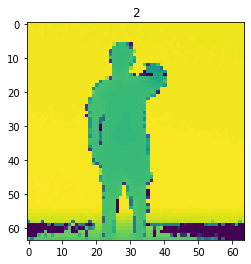

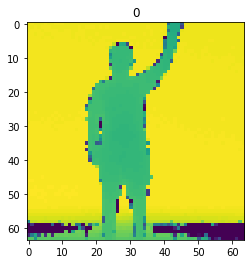

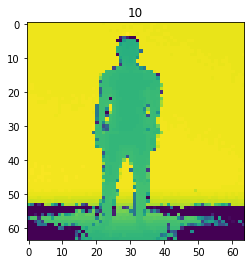

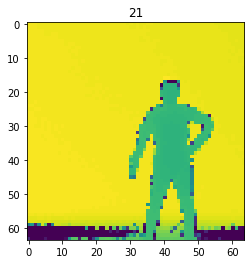

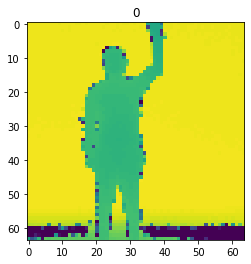

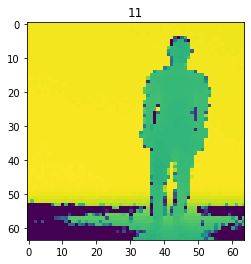

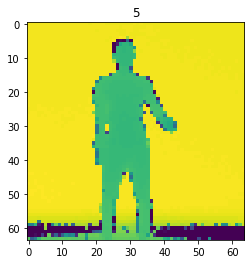

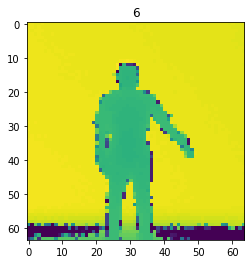

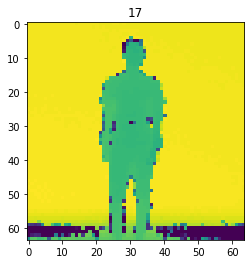

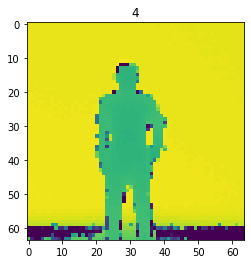

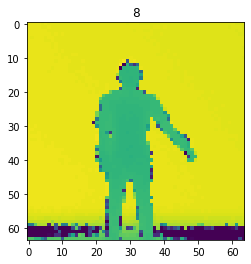

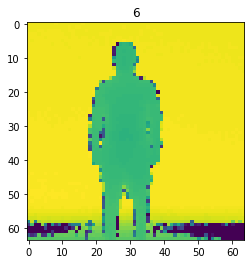

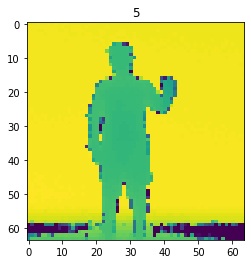

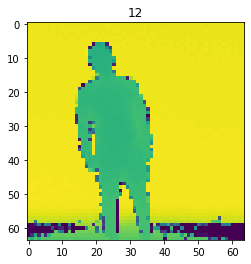

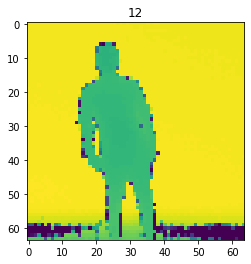

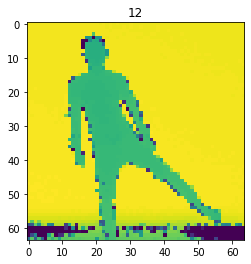

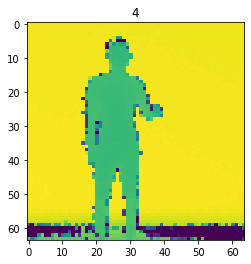

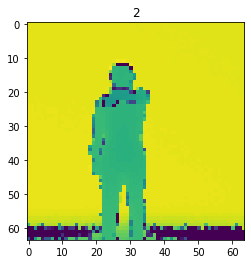

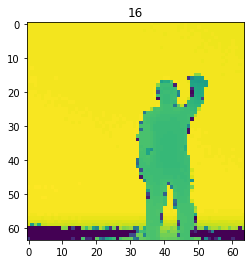

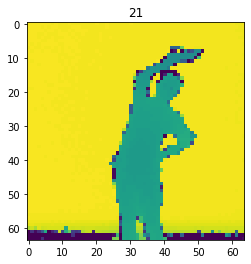

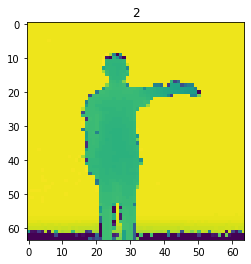

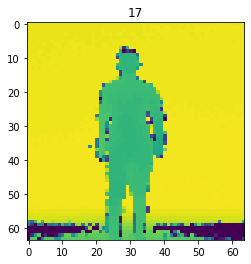

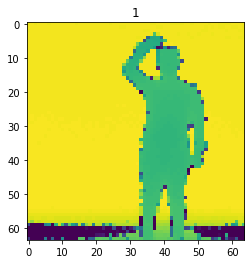

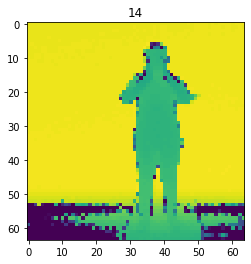

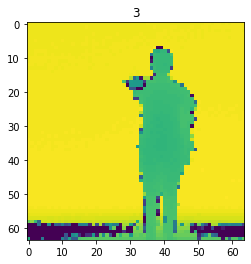

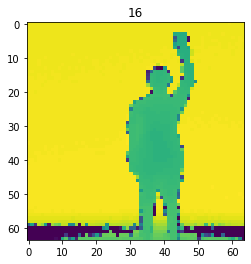

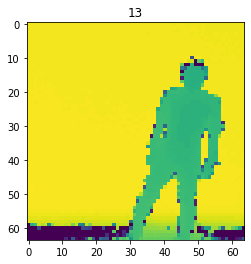

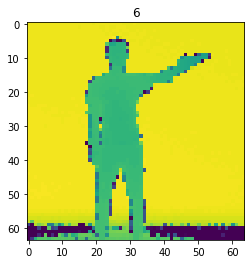

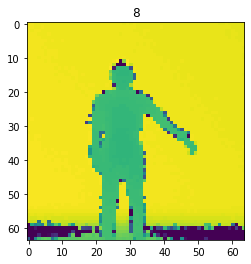

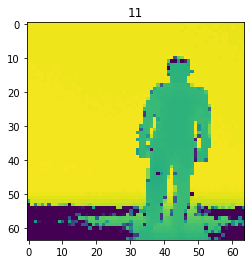

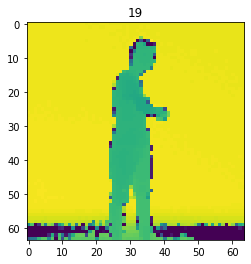

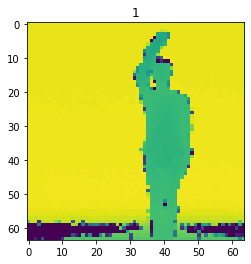

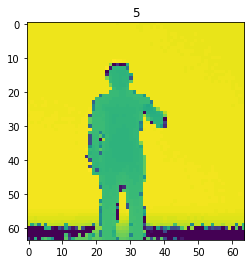

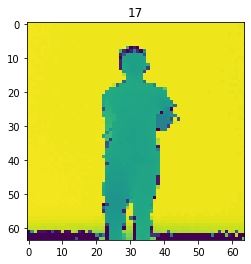

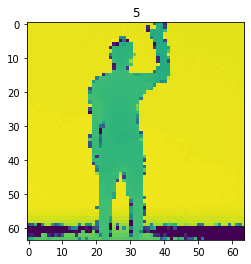

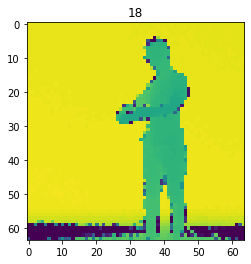

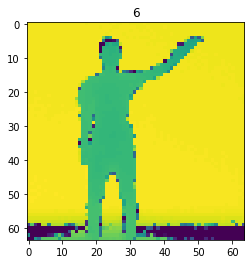

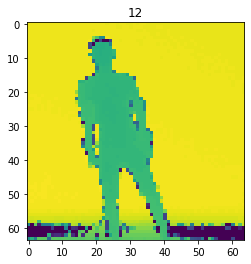

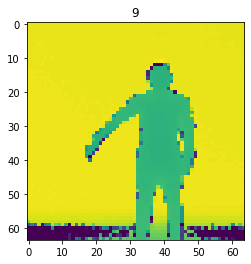

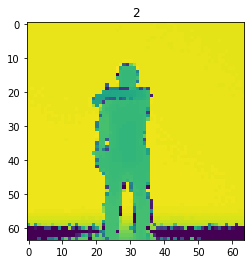

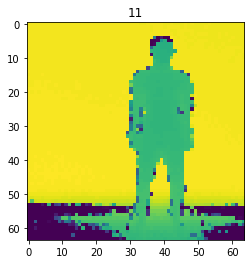

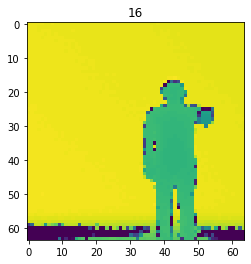

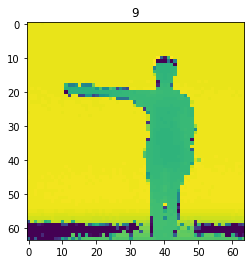

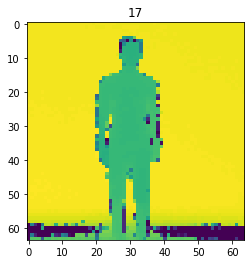

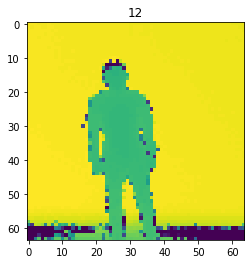

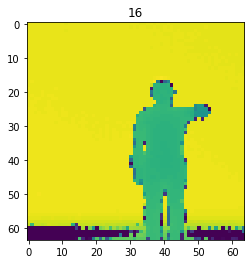

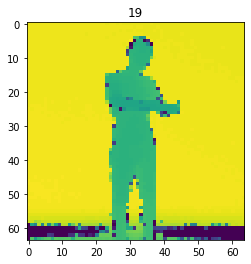

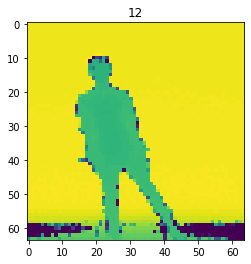

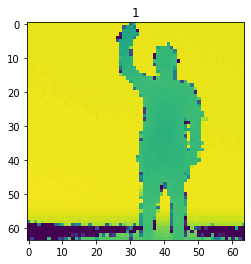

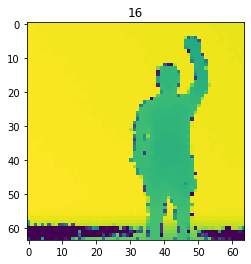

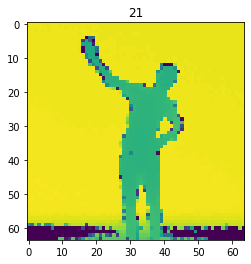

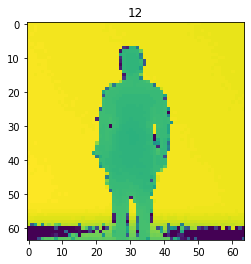

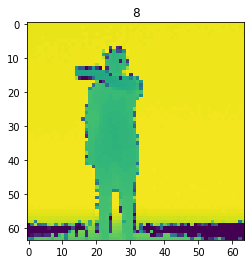

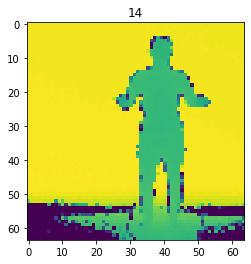

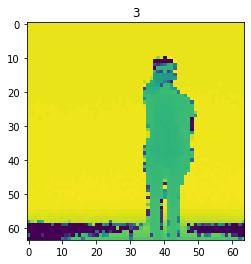

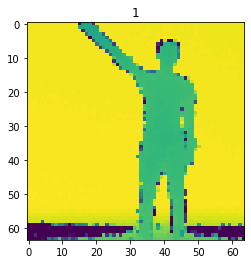

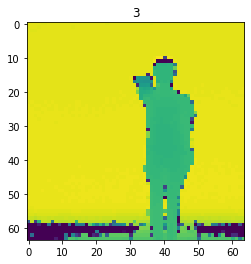

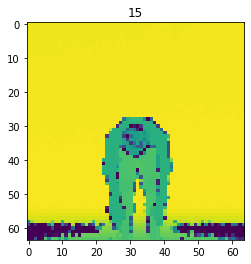

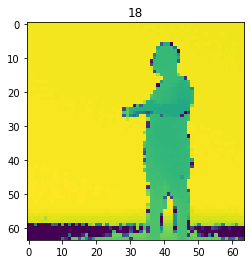

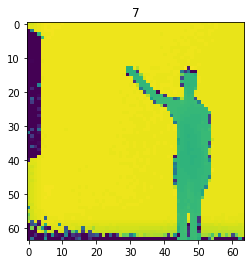

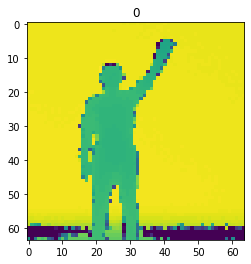

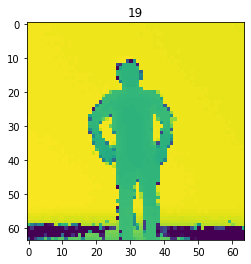

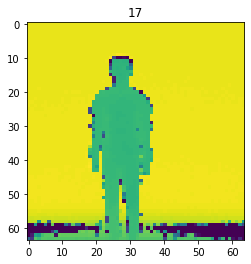

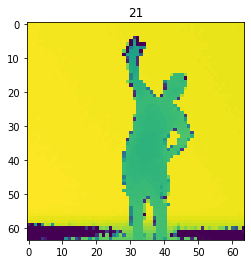

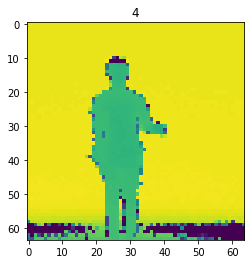

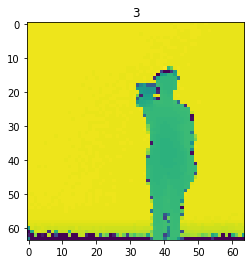

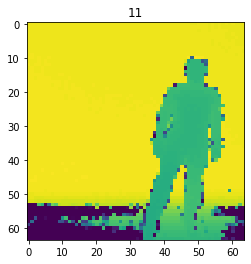

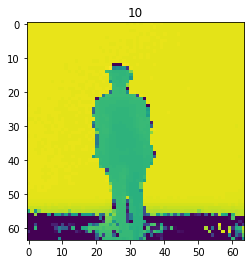

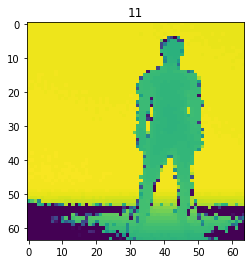

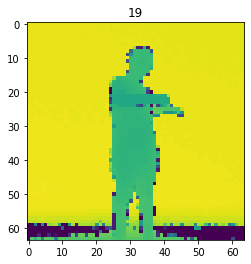

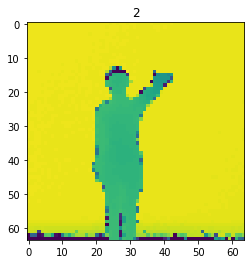

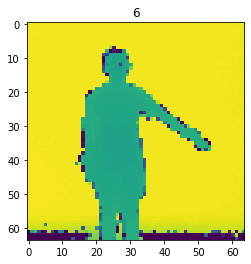

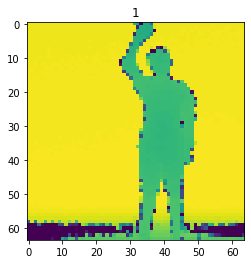

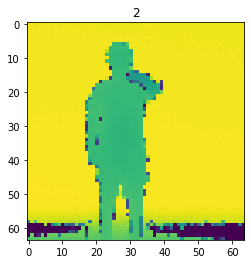

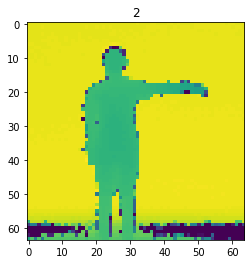

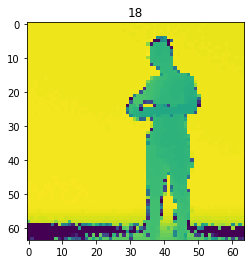

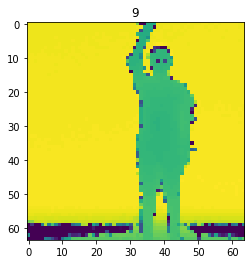

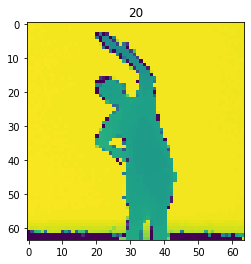

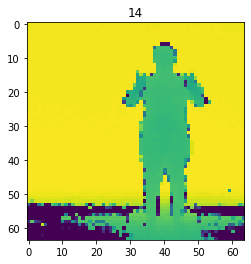

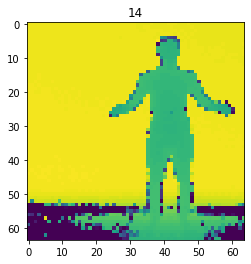

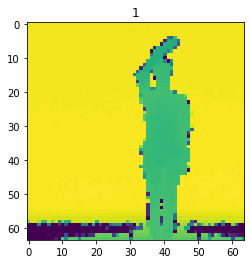

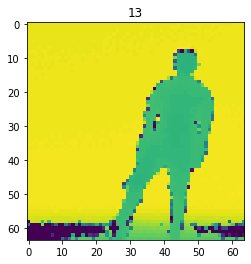

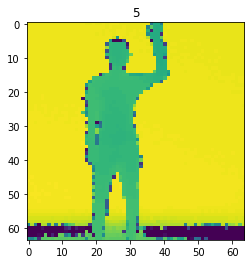

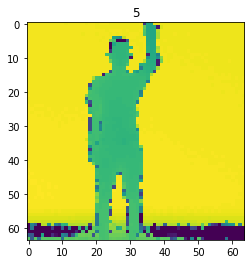

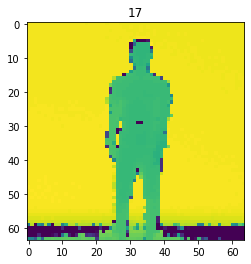

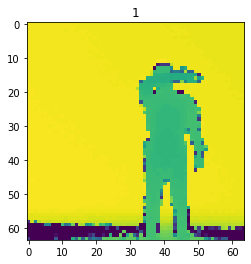

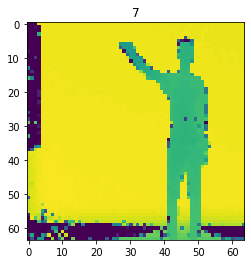

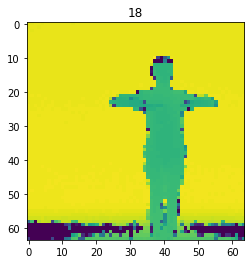

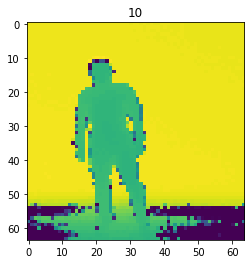

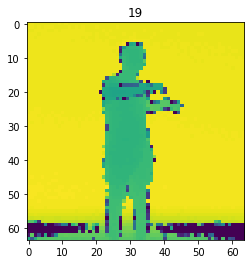

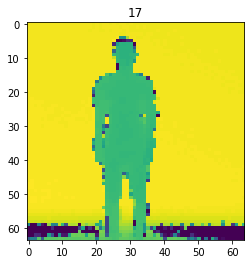

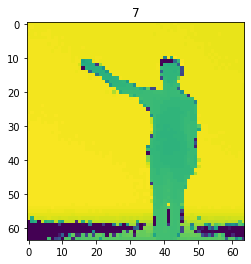

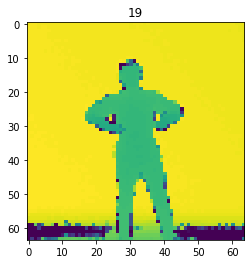

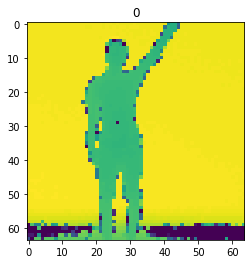

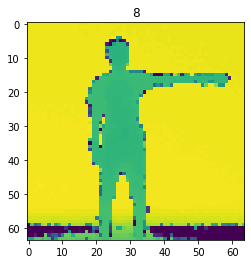

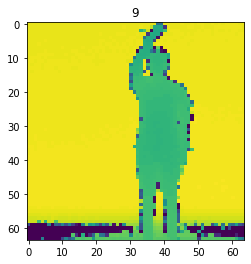

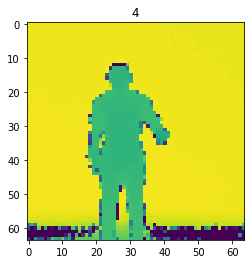

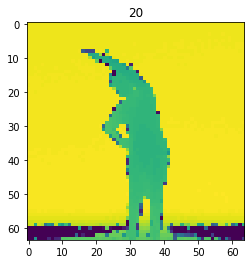

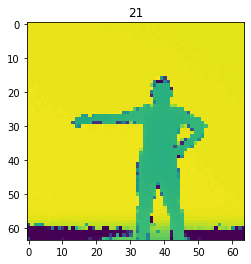

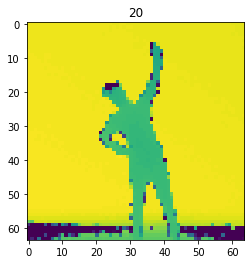

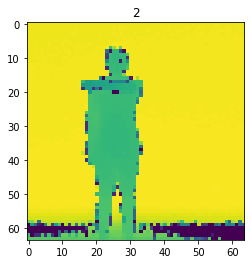

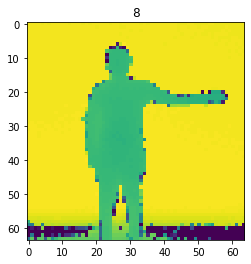

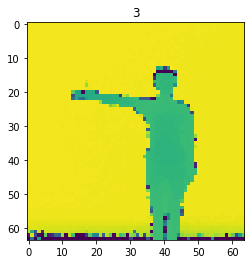

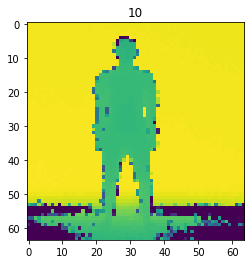

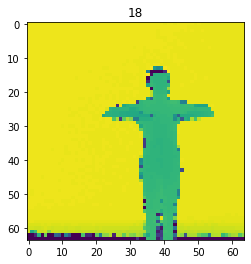

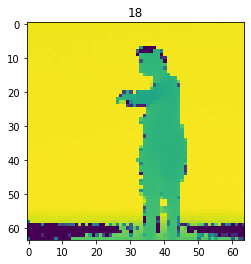

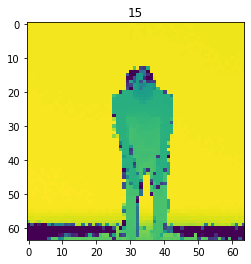

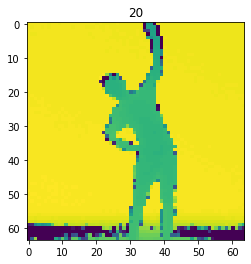

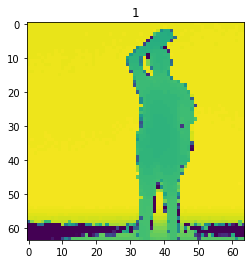

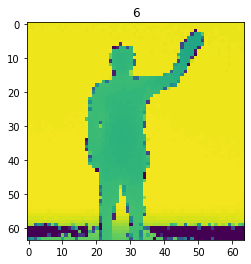

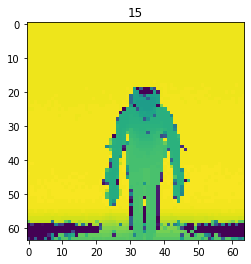

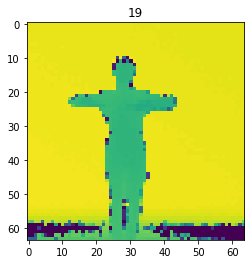

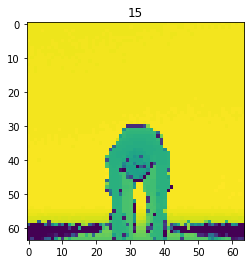

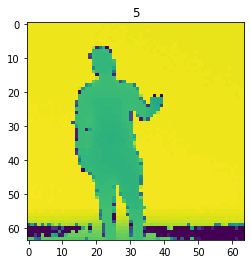

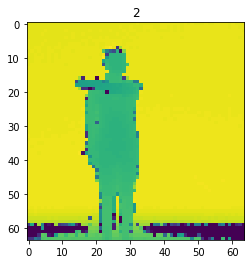

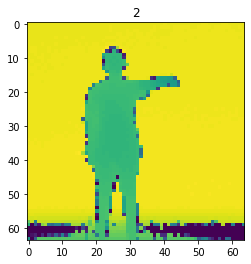

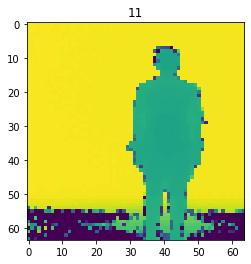

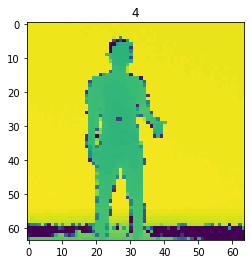

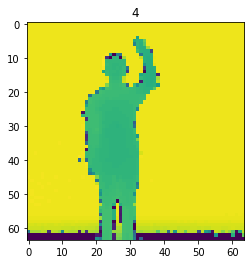

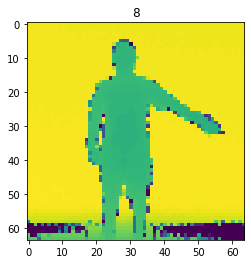

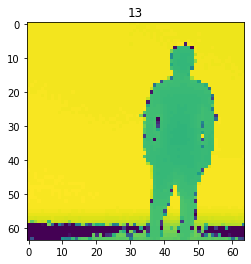

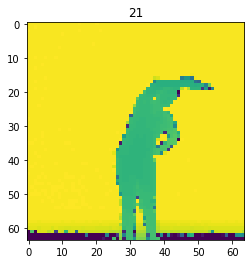

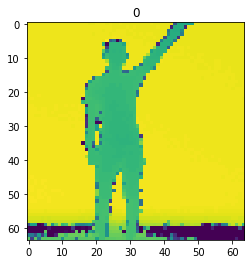

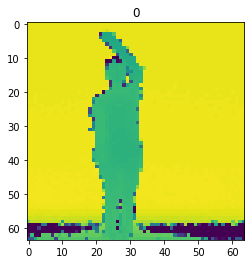

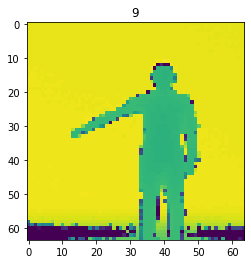

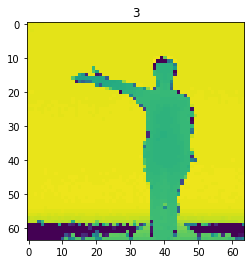

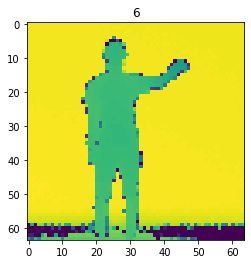

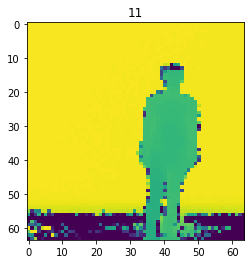

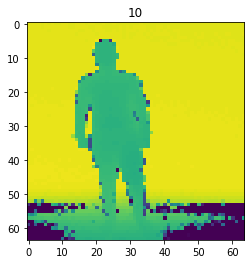

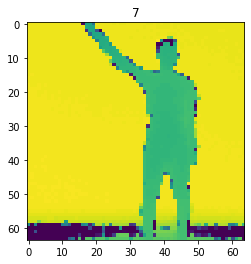

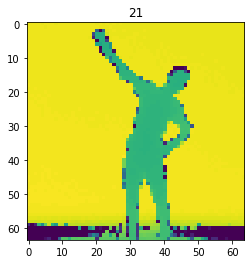

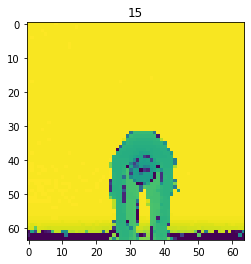

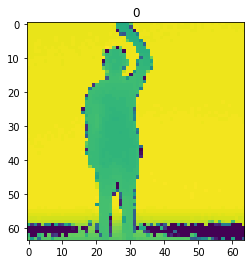

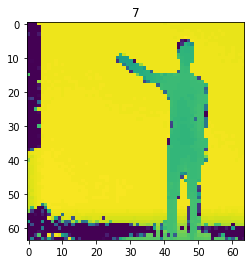

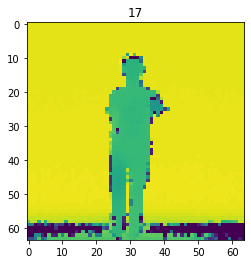

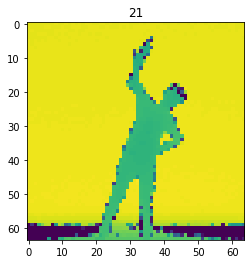

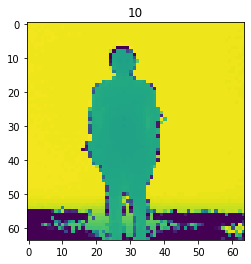

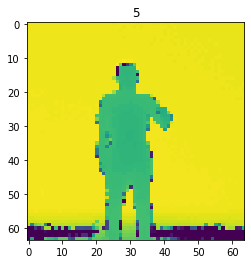

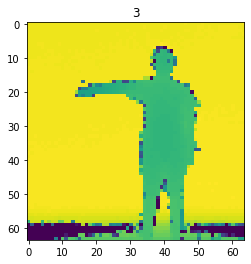

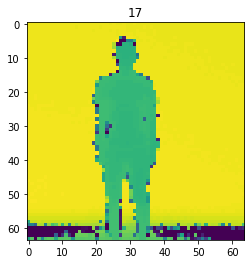

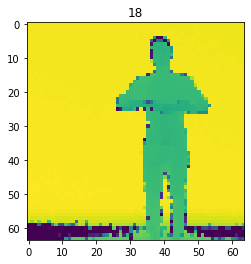

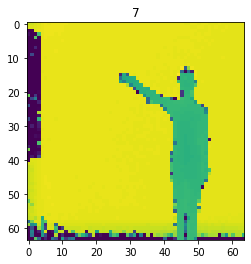

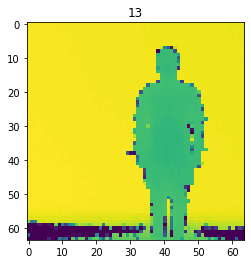

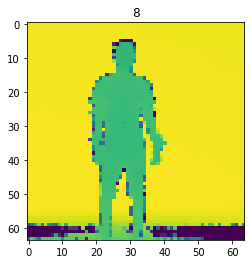

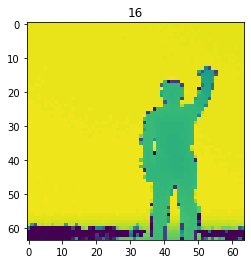

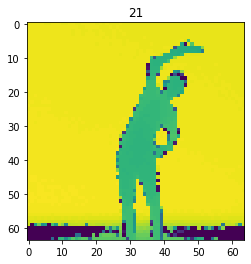

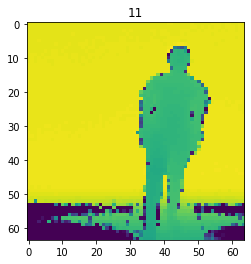

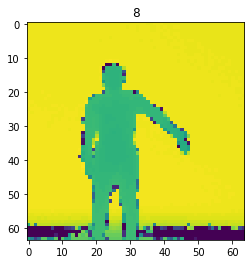

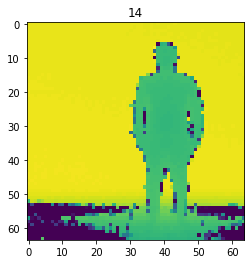

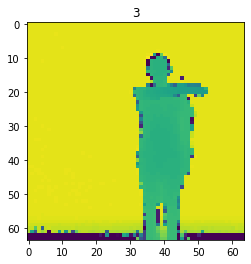

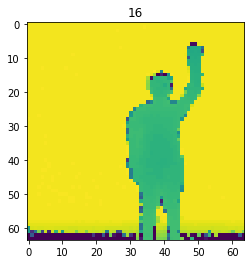

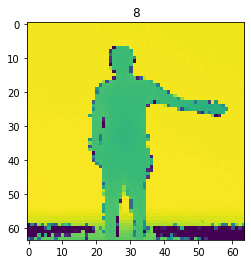

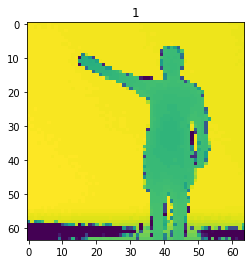

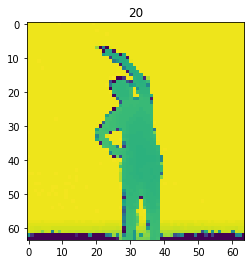

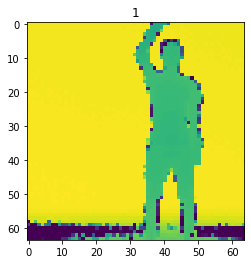

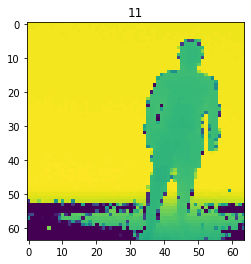

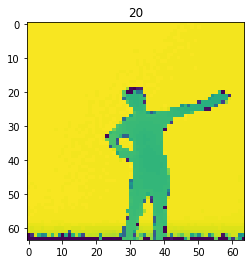

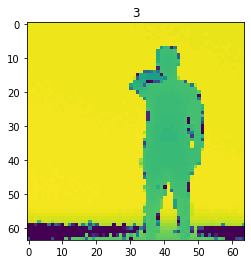

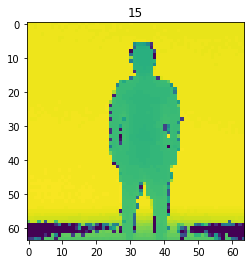

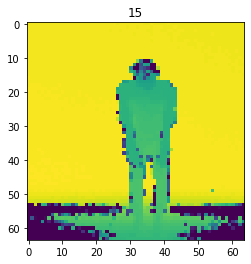

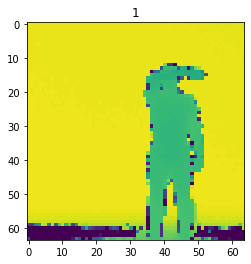

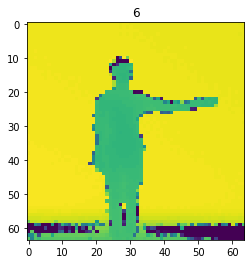

In [ ]:
for i in range(932):
  d = train_x[i][10].reshape(64,64)
  plt.imshow(d, interpolation='nearest')
  plt.title(train_y[i])
  plt.show()
  

In [ ]:
print(train_y.shape)
SEQ_LEN = 50 
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
CLASS_NUM = 22

(932,)


In [ ]:
unique, counts = np.unique(test_y, return_counts=True)
print( dict(zip(unique, counts)) )

{0: 10, 1: 10, 2: 11, 3: 10, 4: 11, 5: 10, 6: 11, 7: 11, 8: 10, 9: 11, 10: 11, 11: 10, 12: 11, 13: 11, 14: 11, 15: 10, 16: 11, 17: 10, 18: 10, 19: 11, 20: 11, 21: 11}


In [ ]:
train_y = to_categorical(train_y)
print(train_y.shape)

(932, 22)


In [ ]:
test_y = to_categorical(test_y)
print(test_y.shape)

(233, 22)


In [ ]:
def create_convlstm_model():

  model = Sequential()

  # define model architecture

  model.add(ConvLSTM2D( filters = 16, kernel_size = (3,3), activation = 'relu',
                       data_format = 'channels_last', recurrent_dropout= 0.2, 
                       return_sequences = True, input_shape = (SEQ_LEN, IMAGE_HEIGHT, IMAGE_WIDTH, 1) ))
  
  model.add(MaxPooling3D( pool_size = (1,2,2), padding = 'same', data_format = 'channels_last' ))
  model.add(TimeDistributed (Dropout(0.2)))

  model.add(ConvLSTM2D( filters = 32, kernel_size = (3,3), activation = 'relu',
                       data_format = 'channels_last', recurrent_dropout= 0.2, 
                       return_sequences = True) )
  
  model.add(MaxPooling3D( pool_size = (1,2,2), padding = 'same', data_format = 'channels_last' ))
  model.add(TimeDistributed (Dropout(0.2)))

  model.add(ConvLSTM2D( filters = 64, kernel_size = (3,3), activation = 'relu',
                       data_format = 'channels_last', recurrent_dropout= 0.2, 
                       return_sequences = True) )
  
  model.add(MaxPooling3D( pool_size = (1,2,2), padding = 'same', data_format = 'channels_last' ))
  model.add(TimeDistributed (Dropout(0.2)))

  model.add(ConvLSTM2D( filters = 64, kernel_size = (3,3), activation = 'relu',
                       data_format = 'channels_last', recurrent_dropout= 0.2, 
                       return_sequences = True) )
  model.add(MaxPooling3D( pool_size = (1,2,2), padding = 'same', data_format = 'channels_last' ))
  #model.add(TimeDistributed (Dropout(0.2)))


  # use global avg pooling instead of flatten
  # model.add(Flatten())
  model.add(GlobalAveragePooling3D())

  model.add( Dense(CLASS_NUM, activation = 'softmax') )
  model.summary()

  return model

In [ ]:
convLSTM_model = create_convlstm_model()

print("model created successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 50, 62, 62, 4)     736       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 50, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 50, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 50, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 50, 15, 15, 8)    0         
 3D)                                                             
                                                        

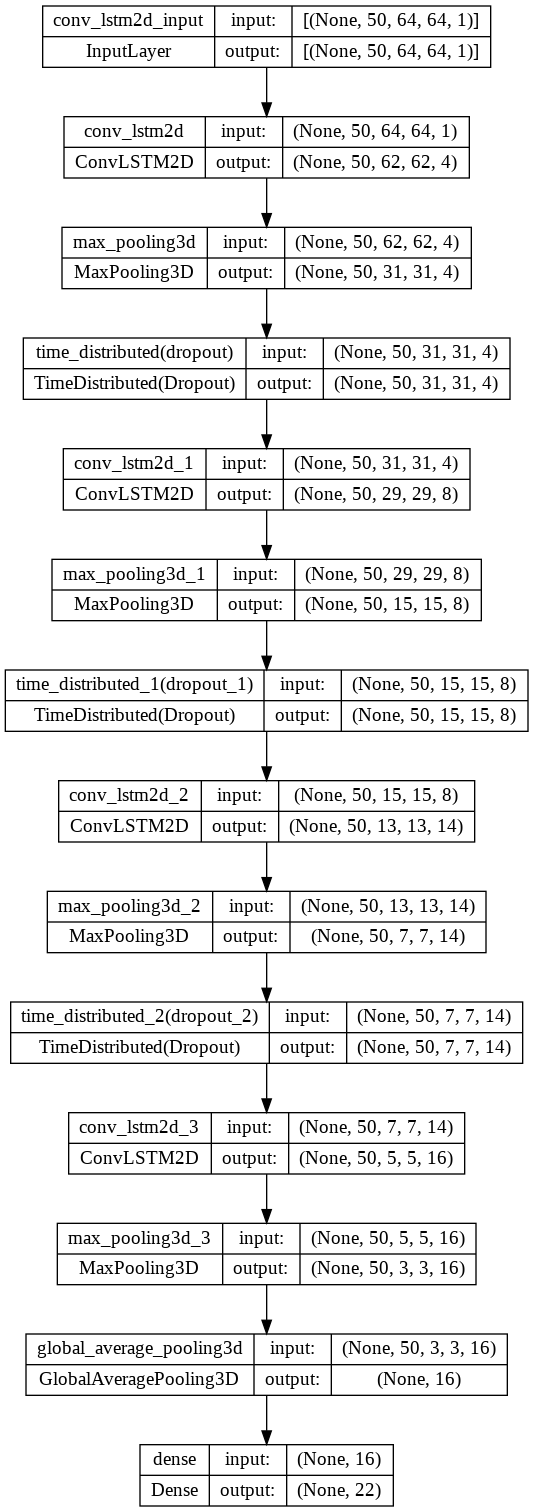

In [ ]:
plot_model(convLSTM_model, to_file = 'convLSTM_model_structure.png', show_shapes = True, show_layer_names= True)

In [ ]:
# import keras as keras
# from keras.optimizers import SGD
# from sklearn.metrics import precision_score, recall_score

In [ ]:
# metrics=['accuracy']
# class Metrics(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self._data = []

#     def on_epoch_end(self, batch, logs={}):
#         X_val, y_val = self.validation_data[0], self.validation_data[1]
#         y_predict = np.asarray(model.predict(X_val))

#         y_val = np.argmax(y_val, axis=1)
#         y_predict = np.argmax(y_predict, axis=1)

#         self._data.append({
#             'val_recall': recall_score(y_val, y_predict),
#             'val_precision': precision_score(y_val, y_predict),
#         })
#         return

#     def get_data(self):
#         return self._data


# metrics = Metrics()

In [ ]:
# add an early stopping callback to avoid overfitting
early_stop_callback = EarlyStopping(monitor = 'val_loss', patience = 10 , mode = 'min', restore_best_weights = True)
convLSTM_model.compile(loss = 'categorical_crossentropy' ,optimizer = 'Adam' , metrics = ['accuracy'])

In [ ]:
convLSTM_model_training_history = convLSTM_model.fit( x = train_x, y = train_y, epochs = 30, batch_size = 12,
                                                     shuffle = True, validation_split = 0.2, callbacks = [early_stop_callback] )

Epoch 1/30
63/63 [==============================] - 111s 1s/step - loss: 3.0922 - accuracy: 0.0403 - val_loss: 3.0918 - val_accuracy: 0.0481
Epoch 2/30
63/63 [==============================] - 87s 1s/step - loss: 3.0913 - accuracy: 0.0497 - val_loss: 3.0925 - val_accuracy: 0.0267
Epoch 3/30
63/63 [==============================] - 87s 1s/step - loss: 3.1487 - accuracy: 0.0322 - val_loss: 3.0922 - val_accuracy: 0.0481
Epoch 4/30
63/63 [==============================] - 91s 1s/step - loss: 3.0905 - accuracy: 0.0564 - val_loss: 3.0930 - val_accuracy: 0.0267
Epoch 5/30
63/63 [==============================] - 86s 1s/step - loss: 3.0898 - accuracy: 0.0523 - val_loss: 3.0928 - val_accuracy: 0.0428
Epoch 6/30
63/63 [==============================] - 86s 1s/step - loss: 3.1186 - accuracy: 0.0523 - val_loss: 3.0948 - val_accuracy: 0.0267
Epoch 7/30
63/63 [==============================] - 86s 1s/step - loss: 3.0908 - accuracy: 0.0497 - val_loss: 3.0951 - val_accuracy: 0.0267
Epoch 8/30
63/63 [=

In [ ]:
convLSTM_model_evaluation_history = convLSTM_model.evaluate( test_x, test_y)

eval_loss, eval_acc = convLSTM_model_evaluation_history

In [ ]:
date_time_format = 